<a href="https://colab.research.google.com/github/irinazobova/solar-activity-forecast/blob/main/solar_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Датасет: SSN и границы солнечных циклов

To forecast parameters of solar cycle 26, *monthly mean total sunspot number* data is used (source: [WDC-SILSO](https://www.sidc.be/SILSO/datafiles), Royal Observatory of Belgium, Brussels).

Data description:
> Monthly mean total sunspot number obtained by taking a simple arithmetic mean of the daily total sunspot number over all days of each calendar month. Monthly means are available only since 1749 because the original observations compiled by Rudolph Wolf were too sparse before that year. A value of -1 indicates missing value. Data before SC 1 (until 1755-02) was dismissed from the dataset.

Error values:
> The monthly standard deviation of individual data is derived from the daily values by:
σ(m)=sqrt(SUM(N(d)*σ(d)^2)/SUM(N(d)))
where σ(d) is the standard deviation for a single day and N(d) is the number of observations for that day.
The standard error on the monthly mean values can be computed by:
σ/sqrt(N)
where σ is the listed standard deviation and N the total number of observations in the month.

CSV file contents:
> * Column 1-2: Gregorian calendar date
* Column 3: Date in fraction of year.
* Column 4: Monthly mean total sunspot number.
* Column 5: Monthly mean standard deviation of the input sunspot numbers.

In [150]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sympy import fwht, ifwht
from sympy.combinatorics import GrayCode
import scipy
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('legend', fontsize=14) #fontsize of the legend

      year  month  yearfrac    ssn  sigma
0     1755      2  1755.123   18.7   -1.0
1     1755      3  1755.204   11.3   -1.0
2     1755      4  1755.288   10.8   -1.0
3     1755      5  1755.371    0.0   -1.0
4     1755      6  1755.455    0.0   -1.0
...    ...    ...       ...    ...    ...
3219  2023      5  2023.371  137.4   19.6
3220  2023      6  2023.453  160.5   20.0
3221  2023      7  2023.538  159.1   17.3
3222  2023      8  2023.623  114.8   15.4
3223  2023      9  2023.705  133.6   17.6

[3224 rows x 5 columns]

n y_min m_min y_max m_max ssn_max
1 1755 02 1761 06 144 

2 1766 06 1769 09 193 

3 1775 06 1778 05 264 

4 1784 09 1788 02 235 

5 1798 04 1805 02 82 

6 1810 07 1816 05 81 

7 1823 05 1829 11 119 

8 1833 11 1837 03 245 

9 1843 07 1848 02 220 

10 1855 12 1860 02 186 

11 1867 03 1870 08 234 

12 1878 12 1883 12 124 

13 1890 03 1894 01 147 

14 1902 01 1906 02 107 

15 1913 07 1917 08 176 

16 1923 08 1928 04 130 

17 1933 09 1937 04 199 

18 1944 02 1947 05 219

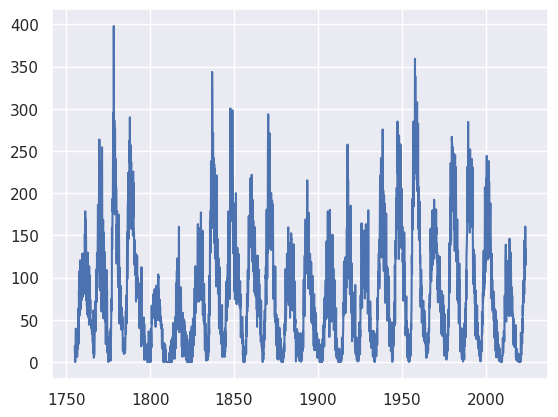

In [151]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/input.csv", sep=';', header = 0)
print(data)
plt.plot(data['yearfrac'],data['ssn'])

f = open('/content/drive/MyDrive/Colab Notebooks/timeframe-wiki.txt')
s = f.read().splitlines()
f.close()
s = list(map(lambda x:x.split(), s))
print('\nn y_min m_min y_max m_max ssn_max')
for i in s:
    for j in i:
        print(j, sep='\t', end=' ')
    print('\n')

# Предобработка данных

## Деление временного ряда на циклы

Выделяем начало / конец каждого цикла. Используем данные [NGDC NOAA](https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-indices/sunspot-numbers/cycle-data/table_cycle-dates_maximum-minimum.txt) или [Википедии](https://en.wikipedia.org/wiki/List_of_solar_cycles) о датах максимума и минимума. Находим индексы строк, соответствующих минимумам солнечной активности (=началам солнечных циклов), в файле наблюдений ***input.csv*** и связываем их с номерами циклов по информации Википедии в файле ***timeframe-wiki.txt***:

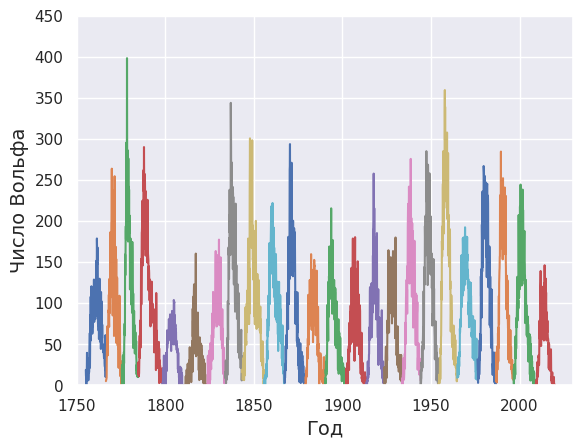

In [152]:
sc_minima_indices = []
for i in range(len(s)):
  sc_minima_indices.append(i+1)
  sc_minima_indices.append(data[(data['year'] == int(s[i][1])) & (data['month'] == int(s[i][2]))].index[0])

list2 = [] #разделить номер цикла и точку начала цикла в файле наблюдений
list2.append(sc_minima_indices[::2])
list2.append(sc_minima_indices[1::2])

cycles_data = dict() #создать словарь из датафреймов каждого цикла
cycles_binwidth = list() #используем этот список для int метода в следующем блоке
cycles_width = list()
cycles_length = list()
for i in range(24):
  cycles_data['num_%s' % (i+1)] = data[(list2[1][i]):(list2[1][i+1])]
  cycles_binwidth.append(int(cycles_data['num_%s' % (i+1)].shape[0] / 16))
  cycles_width.append(cycles_data['num_%s' % (i+1)].shape[0] / 16)
  cycles_length.append(cycles_data['num_%s' % (i+1)].shape[0])

for i in range(24):
  plt.plot(cycles_data['num_%s' % (i+1)]['yearfrac'], cycles_data['num_%s' % (i+1)]['ssn'])
plt.xlim(1750, 2030), plt.xlabel('Год')
plt.ylim(0, 450), plt.ylabel('Число Вольфа')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/cycles.png')

## Деление циклов на фазы

### Метод обрезания хвоста

Нужно перейти к фазам цикла, чтобы посмотреть, как первая фаза меняется с каждым из 24 циклов, как - вторая и т.д., всего получив 16 рядов значений: число пятен в фазе i, зависящее от номера цикла. Важно помнить о способе целочисленного деления циклов на 16 бинов. Ниже реализован метод "обрезания хвоста": округляем по int() результат деления длины цикла на 16, считываем только 16 первых результатов, "лишние" дни остаются в хвосте. Можно посмотреть, насколько обрезанные данные не соответствуют исходным:

In [153]:
name_ssn = "phase_ssn_"
name_sigma = "phase_sigma_"
ssn_matrix_old = list()
sigma_matrix_old = list()
#выделить 16 фаз каждого из циклов без обработки "лишних дней", методом int() - округления снизу
for k in range(16):
  exec(name_ssn + "%s = list()" % (k+1))
  exec(name_sigma + "%s = list()" % (k+1))
  for i in range(24):
    temp_ssn = list()
    temp_sigma = list()
    for j in range(cycles_binwidth[i]):
      temp_ssn.append(cycles_data['num_%s' % (i+1)]['ssn'].values[j+k*cycles_binwidth[i]])
      temp_sigma.append(cycles_data['num_%s' % (i+1)]['sigma'].values[j+k*cycles_binwidth[i]])
    exec(name_ssn + "%s.append(round(np.mean(temp_ssn), 2))" % (k+1))
    exec(name_sigma + "%s.append(round(np.mean(temp_sigma), 2))" % (k+1))
  exec("ssn_matrix_old.append(" + name_ssn + "%s)" % (k+1))
  exec("sigma_matrix_old.append(" + name_sigma + "%s)" % (k+1))

for j in range(16): #матрица: в строке слева направо - ссн циклов от 1го до 24го
  for i in range(24): #в столбцах сверху вниз - ссн по фазам от 1й до 16й
    print(ssn_matrix_old[j][i], end='\t') #3 строка, 2 столбец: 3я фаза 2го цикла
  print('\n')

11.26	7.03	12.53	22.52	5.62	0.0	0.11	12.63	18.54	5.98	12.28	4.8	12.75	5.3	3.24	10.43	5.81	9.74	5.29	18.85	20.27	13.86	12.87	2.5	

20.27	50.65	22.37	70.14	12.09	3.14	17.84	29.0	26.26	13.35	39.95	25.01	36.09	20.89	12.63	31.06	15.47	29.29	21.86	24.41	21.29	42.23	37.52	13.75	

18.65	65.98	34.78	169.52	13.83	6.96	12.63	59.37	63.16	49.66	87.51	59.76	86.78	47.45	39.03	34.04	29.96	64.47	74.33	62.06	45.94	66.86	88.4	25.29	

50.9	94.35	93.42	223.94	37.2	12.5	30.74	149.73	90.31	83.0	121.94	84.0	122.26	67.97	92.23	84.46	78.74	105.83	163.61	116.35	109.86	154.61	125.32	54.2	

80.84	122.23	182.33	224.44	59.61	26.04	32.77	189.71	108.09	144.1	209.31	95.74	129.24	86.14	93.11	114.04	110.94	176.01	240.1	136.94	157.6	202.27	158.93	98.6	

75.46	134.6	267.18	195.04	77.29	23.58	60.73	262.11	182.98	185.99	220.92	102.55	148.43	109.42	88.31	111.4	178.97	212.73	258.7	149.65	194.69	216.87	168.92	90.89	

90.89	219.0	261.92	179.34	66.41	53.56	83.27	212.74	201.89	179.23	192.88	96.39	135.76	97.69	158.33	119.8	196.09	1

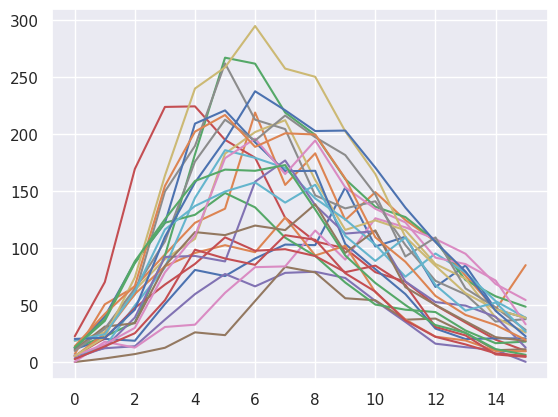

In [154]:
plt.plot(ssn_matrix_old) #24 цикла усреднили по 16 значений и наложили друг на друга
plt.show()

### Метод взвешивания

Для честного разбиения данных важно, чтобы обрезания хвоста не происходило. Поэтому SSN в месяцы, расположенные на границе между фазами, будет суммироваться с другими SSN месяцев фазы, но с поправочным коэффициентом - весом от 0 до 1. Сумма взвешенных значений будет делиться не на число месяцев, данные об SSN которых использовались, а на среднюю ширину фазы - нецелое число.

Сначала создаем список, который хранит вес всех месяцев внутри каждого солнечного цикла.

In [155]:
weights = [] #список весов для всех месяцев всех циклов
phase_numbers = [] #список номеров фаз для всех месяцев всех циклов
for i in range(24):
    temp = [] #список весов для каждого месяца в отдельно взятом цикле
    phnum = [] #список номеров фаз для каждого месяца в отдельно взятом цикле
    for m in range(cycles_length[i]):
      temp.append(0) #чтобы потом присваивать значения по индексам, заполняем список весов нулями
      phnum.append(0)
    #1 фаза цикла
    temp[:cycles_binwidth[i]] = [1]*cycles_binwidth[i]
    phnum[:cycles_binwidth[i]] = [1]*cycles_binwidth[i]
    temp[cycles_binwidth[i]] = cycles_width[i] - cycles_binwidth[i]
    phnum[cycles_binwidth[i]] = 1.5
    lst = temp[cycles_binwidth[i]] #запоминаем вес последнего месяца фазы
    #2-15 фазы цикла
    for q in range(14):
      nxt = 1 - lst #вычисляем, какой будет вес у этого же месяца в следующей фазе
      nmnth = int(cycles_width[i]-nxt) #вычисляем, сколько в фазе уложится месяцев с весом 1
      for p in range(nmnth):
        temp[temp.index(0)] = 1
        phnum[phnum.index(0)] = q+2
      temp[temp.index(0)] = cycles_width[i]-nxt-nmnth
      phnum[phnum.index(0)] = q+2.5
      lst = cycles_width[i]-nxt-nmnth
    #16 фаза цикла
    while (temp.index(0) < cycles_length[i]-1):
      temp[temp.index(0)] = 1
    while (phnum.index(0) < cycles_length[i]-1):
      phnum[phnum.index(0)] = 16
    temp[-1] = 1
    phnum[-1] = 16
    #собираем циклы воедино
    weights.append(temp)
    phase_numbers.append(phnum)
#weights[2][3] - вес 4 месяца для 3 солнечного цикла, phase_numbers[2][3] - номер фазы для того же месяца

Теперь, наконец, усредняем значения SSN по фазам со взвешиванием значений. Можно увидеть, как выглядит разбиение относительно предыдущего и относительно оригинальной картины цикла.

In [156]:
name_ssn = "phase_ssn_"
name_sigma = "phase_sigma_"
ssn_matrix = list()
sigma_matrix = list()

for k in range(16):
  exec(name_ssn + "%s = list()" % (k+1))
  exec(name_sigma + "%s = list()" % (k+1))
  for i in range(24):
    wd = cycles_width[i]
    ssn_wsum, sigma_wsum = 0, 0
    for j in range(cycles_length[i]): #для всех месяцев в i-м цикле взвешиваем ssn и sigma, суммируем
      if (abs(phase_numbers[i][j]-1 - k) <= 0.5): #если этот месяц внутри фазы или на её границе
        ssn_wsum += cycles_data['num_%s' % (i+1)]['ssn'].values[j]*weights[i][j]
        sigma_wsum += cycles_data['num_%s' % (i+1)]['sigma'].values[j]*weights[i][j]
      else: #если этот месяц относится к другой фазе
        ssn_wsum += 0
        sigma_wsum += 0
    exec(name_ssn + "%s.append(round(ssn_wsum/wd, 2))" % (k+1))
    exec(name_sigma + "%s.append(round(sigma_wsum/wd, 2))" % (k+1))
  exec("ssn_matrix.append(" + name_ssn + "%s)" % (k+1))
  exec("sigma_matrix.append(" + name_sigma + "%s)" % (k+1))

for j in range(16): #матрица: в строке слева направо - ссн циклов от 1го до 24го
  for i in range(24): #в столбцах сверху вниз - ссн по фазам от 1й до 16й
    print(ssn_matrix[j][i], end='\t') #например 3 строка, 2 столбец: 3я фаза 2го цикла
  print('\n')

12.92	9.81	12.62	23.22	5.56	0.0	3.88	12.64	19.08	6.25	12.81	5.48	13.06	5.83	3.33	9.88	7.16	10.89	6.19	19.14	21.32	15.75	13.21	2.42	

19.99	54.76	24.01	69.69	11.92	4.98	15.54	27.5	25.69	14.09	45.43	25.88	48.0	22.43	14.46	34.83	17.32	34.4	28.59	26.27	27.11	42.01	37.16	13.96	

22.24	78.18	53.03	165.01	15.17	6.18	19.68	66.66	66.14	57.9	97.88	64.28	97.43	49.07	45.86	38.17	43.55	62.46	107.94	66.13	63.35	84.34	91.19	26.12	

69.38	112.32	148.78	230.49	38.99	16.79	30.44	196.58	97.6	90.23	136.49	88.26	130.11	76.34	93.46	106.88	99.64	139.56	209.61	126.96	133.4	165.95	146.18	74.35	

77.65	133.68	244.39	229.19	65.12	26.51	51.7	196.28	104.39	163.14	233.91	109.88	144.38	94.16	94.76	92.45	121.73	182.21	243.84	133.04	182.89	221.92	164.06	101.94	

90.2	197.67	294.33	210.64	82.94	29.09	72.68	270.67	208.91	169.89	186.52	84.41	140.34	94.04	112.94	138.49	178.28	215.36	284.69	160.21	232.0	185.48	170.91	92.81	

97.84	204.38	227.35	160.66	63.29	67.78	80.42	235.4	213.68	190.67	174.82	104.76	103.73	100.49	181.46

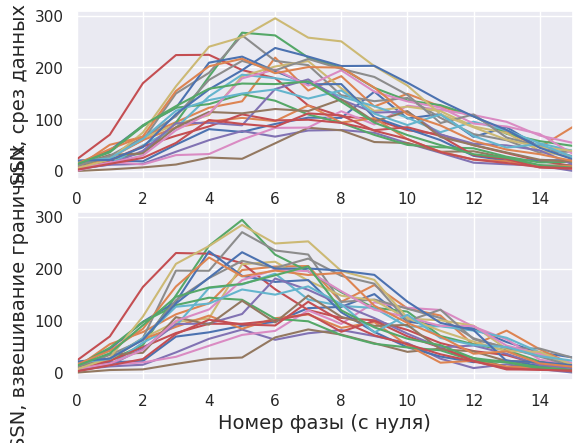

In [157]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ssn_matrix_old), ax2.plot(ssn_matrix)
ax1.set_xlim(0,15), ax2.set_xlim(0,15)
ax2.set_xlabel('Номер фазы (c нуля)')
ax1.set_ylabel('SSN, срез данных')
ax2.set_ylabel('SSN, взвешивание граничных')
plt.show()

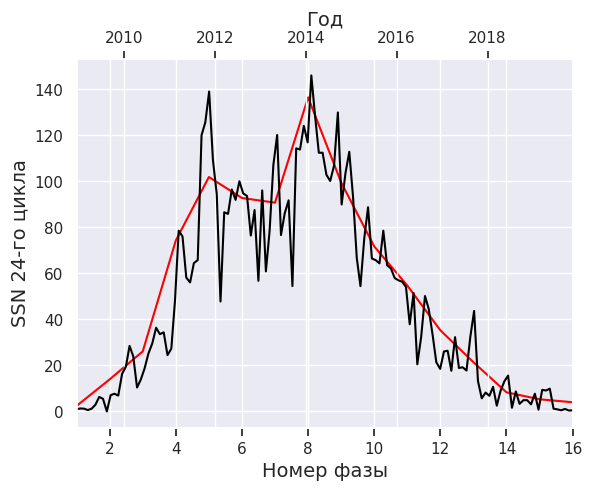

In [158]:
ssn_transposed = np.transpose(ssn_matrix) #24 строки у траспонированного, 16 столбцов
sigma_transposed = np.transpose(sigma_matrix)
n=24
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(range(1,17), ssn_transposed[n-1], color='red')
ax2.plot(cycles_data['num_%s' % n]['yearfrac'], cycles_data['num_%s' % n]['ssn'], color='black')
ax1.set_xlim(1,16)
ax2.set_xlim(cycles_data['num_%s' % n]['yearfrac'].values[0],cycles_data['num_%s' % n]['yearfrac'].values[-1])
ax1.set_xlabel('Номер фазы'), ax2.set_xlabel('Год')
ax1.set_ylabel('SSN %s-го цикла' % n)
plt.show()

## Оценка ошибок в данных

In [159]:
# заранее создадим список погрешностей по фазам - усреднение за нечетные/четные циклы. не будем разложение проводить, потому что это д.б. шум без трендов, частот, етс
sigmas=[]
for j in range(0, 24, 2):
  sigmas.append(np.transpose(sigma_matrix)[j])
data_errs = []
for k in range(16):
  data_errs.append(np.mean(np.transpose(sigmas)[k]))
  print(round(data_errs[k], 2))
print('\n')
sigmas26=[]
for j in range(1, 25, 2):
  sigmas26.append(np.transpose(sigma_matrix)[j])
data_errs26 = []
for k in range(16):
  data_errs26.append(np.mean(np.transpose(sigmas26)[k]))
  print(round(data_errs26[k], 2))

2.19
3.51
5.47
7.27
7.74
8.52
8.91
9.15
7.89
7.46
6.53
5.84
5.14
3.96
3.09
2.17


2.05
3.18
4.89
7.55
8.21
8.18
8.25
8.68
7.46
7.57
6.72
6.03
4.77
3.89
3.35
2.46


# Декомпозиция

Если число фаз в цикле представимо в виде 2n, становится возможным разложение временного ряда в обобщенный ряд Фурье с базисными функциями Уолша. Номер функции (или строки в матрице) по Уолшу можно получить из номера функции по Адамару в 4 этапа:
*   Сначала номер строки записывается в двоичной системе счисления,
*   потом биты в записи переставляются в обратном порядке.
*   Затем применяется код Грея – двоичный код, в котором две соседние кодовые комбинации различаются только в одном двоичном разряде.
*   Полученная запись переводится из двоичной системы в десятичную.

Так получается базисная матрица Уолша. Прочитать больше об этом: [документация по разложению Уолша FWHT SymPy](https://www.geeksforgeeks.org/python-fast-walsh-hadamard-transform/), [документация по коду Грея](https://docs.sympy.org/latest/modules/combinatorics/graycode.html)

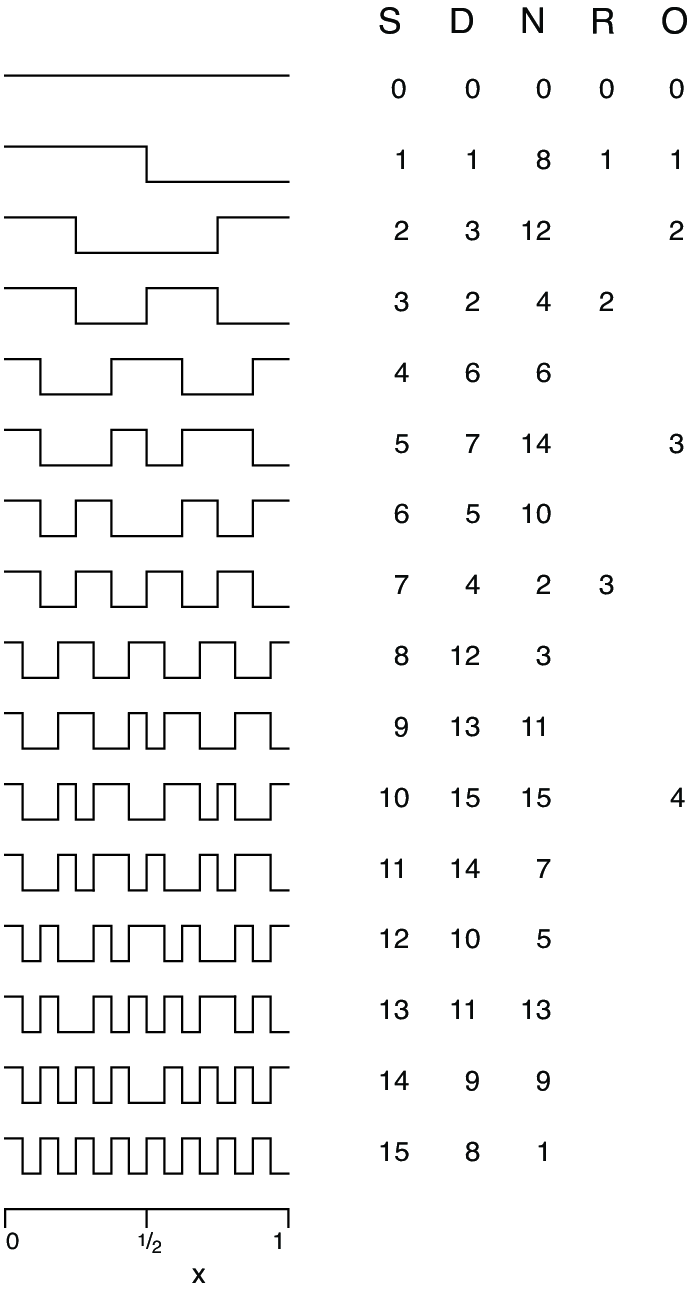

In [160]:
ssn_tmp = []
for i in range(24):
  #применяем преобразование Уолша к матрице 24*16 построчно, преобразованная расположена по Адамару
  ssn_tmp.append(fwht(ssn_transposed[i]))

#по этому порядку расположить значения внутри tmp: это базисные функции Уолша, расположенные по коду Грея
numer = [0,8,12,4,6,14,10,2,3,11,15,7,5,13,9,1]
ssn_walsh = []
tmpp = []
for i in range(24):
  tmpp = ssn_tmp[i]
  ssn_walshh = []
  for j in numer:
    ssn_walshh.append(tmpp[j])
  ssn_walsh.append(ssn_walshh)

for i in range(16): #итоговая матрица преобразованных значений, расположенная по Грею: 1 столбец - это первый коэффициент для 24 циклов, и т.д., всего 16 коэффициентов согл. фазам
  for j in range(24):
    print(format(np.transpose(ssn_walsh)[i][j], '.5g'), end='\t')
  print('\n')
#plt.plot(ssn_walsh) #визуализируем изменение преобразованных значений с фазой

1192.8	1729.4	1799.6	1656.2	626.81	503.41	1060.0	1927.0	1587.8	1465.7	1402.5	904.32	1050.7	891.29	1177.2	1094.8	1532.7	1801.0	2098.8	1392.8	1817.1	1693.2	1404.2	839.37	

-163.91	263.05	600.07	762.54	90.870	-34.370	-271.30	539.59	237.32	200.23	730.04	285.78	501.14	220.57	234.23	236.86	190.61	331.84	666.39	303.62	304.75	507.32	625.97	238.55	

-519.89	-830.39	-1059.4	-476.36	-419.91	-341.87	-539.80	-943.87	-804.90	-725.53	-694.14	-428.80	-362.60	-507.37	-639.43	-525.88	-804.71	-994.22	-1082.5	-601.40	-1049.2	-863.76	-701.55	-527.63	

-10.930	-141.77	-386.51	11.240	-11.210	-15.370	29.280	-309.19	-186.20	-266.49	-267.96	-25.700	-34.880	10.190	-143.61	-46.780	-247.93	-149.38	-273.37	-141.02	-91.930	-104.52	-177.63	-82.890	

8.8900	-50.270	-253.21	-443.08	5.3700	96.010	-85.600	-216.91	-47.280	-148.57	-154.68	-1.5200	-242.42	-30.590	59.110	-56.840	-30.850	-64.420	-167.17	-141.46	-79.850	-107.64	-73.430	9.3700	

-17.830	-44.690	-309.27	-479.48	-96.570	58.750	176.28	-237.27	-35.740	-110.17	-331.

Этого можно было достичь прямым расписыванием функций Уолша:

```
a = np.transpose(ssn_matrix)
q = []
for i in range(24): #матрица: в столбцах сверху вниз - ссн циклов от 1го до 24го
  q1 = +np.sum(a[i])
  q2 = +np.sum(a[i][0:8])-np.sum(a[i][8:16])
  q3 = +np.sum(a[i][0:4])-np.sum(a[i][4:8])-np.sum(a[i][8:12])+np.sum(a[i][12:16])
  q4 = +np.sum(a[i][0:4])-np.sum(a[i][4:8])+np.sum(a[i][8:12])-np.sum(a[i][12:16])
  q5 = +np.sum(a[i][0:2])-np.sum(a[i][2:6])+np.sum(a[i][6:10])-np.sum(a[i][10:14])+np.sum(a[i][14:16])
  q6 = +np.sum(a[i][0:2])-np.sum(a[i][2:6])+np.sum(a[i][6:8])-np.sum(a[i][8:10])+np.sum(a[i][10:14])-np.sum(a[i][14:16])
  q7 = +np.sum(a[i][0:2])-np.sum(a[i][2:4])+np.sum(a[i][4:6])-np.sum(a[i][6:10])+np.sum(a[i][10:12])-np.sum(a[i][12:14])+np.sum(a[i][14:16])
  q8 = +np.sum(a[i][0:2])-np.sum(a[i][2:4])+np.sum(a[i][4:6])-np.sum(a[i][6:8])+np.sum(a[i][8:10])-np.sum(a[i][10:12])+np.sum(a[i][12:14])-np.sum(a[i][14:16])
  q9 = +np.sum(a[i][0:1])-np.sum(a[i][1:3])+np.sum(a[i][3:5])-np.sum(a[i][5:7])+np.sum(a[i][7:9])-np.sum(a[i][9:11])+np.sum(a[i][11:13])-np.sum(a[i][13:15])+np.sum(a[i][15:16])
  q10 = +np.sum(a[i][0:1])-np.sum(a[i][1:3])+np.sum(a[i][3:5])-np.sum(a[i][5:7])+np.sum(a[i][7:8])-np.sum(a[i][8:9])+np.sum(a[i][9:11])-np.sum(a[i][11:13])+np.sum(a[i][13:15])-np.sum(a[i][15:16])
  q11 = +np.sum(a[i][0:1])-np.sum(a[i][1:3])+np.sum(a[i][3:4])-np.sum(a[i][4:5])+np.sum(a[i][5:7])-np.sum(a[i][7:9])+np.sum(a[i][9:11])-np.sum(a[i][11:12])+np.sum(a[i][12:13])-np.sum(a[i][13:15])+np.sum(a[i][15:16])
  q12 = +np.sum(a[i][0:1])-np.sum(a[i][1:3])+np.sum(a[i][3:4])-np.sum(a[i][4:5])+np.sum(a[i][5:7])-np.sum(a[i][7:8])+np.sum(a[i][8:9])-np.sum(a[i][9:11])+np.sum(a[i][11:12])-np.sum(a[i][12:13])+np.sum(a[i][13:15])-np.sum(a[i][15:16])
  q13 = +np.sum(a[i][0:1])-np.sum(a[i][1:2])+np.sum(a[i][2:3])-np.sum(a[i][3:5])+np.sum(a[i][5:6])-np.sum(a[i][6:7])+np.sum(a[i][7:9])-np.sum(a[i][9:10])+np.sum(a[i][10:11])-np.sum(a[i][11:13])+np.sum(a[i][13:14])-np.sum(a[i][14:15])+np.sum(a[i][15:16])
  q14 = +np.sum(a[i][0:1])-np.sum(a[i][1:2])+np.sum(a[i][2:3])-np.sum(a[i][3:5])+np.sum(a[i][5:6])-np.sum(a[i][6:7])+np.sum(a[i][7:8])-np.sum(a[i][8:9])+np.sum(a[i][9:10])-np.sum(a[i][10:11])+np.sum(a[i][11:13])-np.sum(a[i][13:14])+np.sum(a[i][14:15])-np.sum(a[i][15:16])
  q15 = +np.sum(a[i][0:1])-np.sum(a[i][1:2])+np.sum(a[i][2:3])-np.sum(a[i][3:4])+np.sum(a[i][4:5])-np.sum(a[i][5:6])+np.sum(a[i][6:7])-np.sum(a[i][7:9])+np.sum(a[i][9:10])-np.sum(a[i][10:11])+np.sum(a[i][11:12])-np.sum(a[i][12:13])+np.sum(a[i][13:14])-np.sum(a[i][14:15])+np.sum(a[i][15:16])
  q16 = +np.sum(a[i][0:1])-np.sum(a[i][1:2])+np.sum(a[i][2:3])-np.sum(a[i][3:4])+np.sum(a[i][4:5])-np.sum(a[i][5:6])+np.sum(a[i][6:7])-np.sum(a[i][7:8])+np.sum(a[i][8:9])-np.sum(a[i][9:10])+np.sum(a[i][10:11])-np.sum(a[i][11:12])+np.sum(a[i][12:13])-np.sum(a[i][13:14])+np.sum(a[i][14:15])-np.sum(a[i][15:16])
  q.append([q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11, q12, q13, q14, q15, q16])

for i in range(24):
  for j in range(16):
    print(format(q[i][j], '.5g'), end='\t')
  print('\n')
```

# Аппроксимация

По методу главных компонентов (англ. principal component analysis, PCA) происходит последовательно выделение:
*   тренд
*   сезонность
*   остатки (шум)

Для выделения компонентов пользуюсь калькуляторами [логарифмической](https://stats.blue/Stats_Suite/logarithmic_regression_calculator.html) и [линейной](https://stats.blue/Stats_Suite/correlation_regression_calculator.html) регрессии, [калькулятором синусоиды](https://stats.blue/Stats_Suite/sinusoidal_regression_calculator.html).
На каждом этапе использую [normal probability test](https://en.wikipedia.org/wiki/Normal_probability_plot) для проверки случайности остатков ([документация](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)).


## Цикл 25

### Выделение тренда



```
qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i in range(0, 24, 2):
  qoddt1.append(ssn_walsh[i][0])
  qoddt2.append(ssn_walsh[i][1])
  qoddt3.append(ssn_walsh[i][2])
  qoddt4.append(ssn_walsh[i][3])
  qoddt5.append(ssn_walsh[i][4])
  qoddt6.append(ssn_walsh[i][5])
  qoddt7.append(ssn_walsh[i][6])
  qoddt8.append(ssn_walsh[i][7])
  qoddt9.append(ssn_walsh[i][8])
  qoddt10.append(ssn_walsh[i][9])
  qoddt11.append(ssn_walsh[i][10])
  qoddt12.append(ssn_walsh[i][11])
  qoddt13.append(ssn_walsh[i][12])
  qoddt14.append(ssn_walsh[i][13])
  qoddt15.append(ssn_walsh[i][14])
  qoddt16.append(ssn_walsh[i][15])
ssn_waltp = np.array([qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16])
ssn_waltp
```



In [161]:
ssn_waltp = np.array([[1192.85000000000, 1799.57000000000, 626.810000000000,
        1059.98000000000, 1587.82000000000, 1402.50000000000,
        1050.74000000000, 1177.25000000000, 1532.71000000000,
        2098.83000000000, 1817.11000000000, 1404.17000000000],
       [-163.910000000000, 600.070000000000, 90.8700000000000,
        -271.300000000000, 237.320000000000, 730.040000000000,
        501.140000000000, 234.230000000000, 190.610000000000,
        666.390000000000, 304.750000000000, 625.970000000000],
       [-519.890000000000, -1059.37000000000, -419.910000000000,
        -539.800000000000, -804.900000000000, -694.140000000000,
        -362.600000000000, -639.430000000000, -804.710000000000,
        -1082.53000000000, -1049.21000000000, -701.550000000000],
       [-10.9300000000000, -386.510000000000, -11.2100000000000,
        29.2800000000000, -186.200000000000, -267.960000000000,
        -34.8800000000000, -143.610000000000, -247.930000000000,
        -273.370000000000, -91.9299999999999, -177.630000000000],
       [8.89000000000003, -253.210000000000, 5.36999999999996,
        -85.6000000000000, -47.2800000000000, -154.680000000000,
        -242.420000000000, 59.1100000000000, -30.8500000000000,
        -167.170000000000, -79.8500000000000, -73.4300000000000],
       [-17.8300000000001, -309.270000000000, -96.5700000000000,
        176.280000000000, -35.7400000000000, -331.980000000000,
        -254.740000000000, -35.7100000000000, -18.6300000000000,
        -451.930000000000, -244.850000000000, -185.790000000000],
       [-278.570000000000, -204.470000000000, -114.550000000000,
        -205.380000000000, -368.160000000000, -250.040000000000,
        -150.520000000000, -432.490000000000, -381.270000000000,
        -490.690000000000, -356.530000000000, -366.190000000000],
       [52.6700000000001, 106.230000000000, 59.0300000000000,
        -8.09999999999997, -24.7000000000000, 32.1800000000000,
        -18.2400000000000, -77.0300000000000, -44.0900000000000,
        -21.2900000000000, 87.9500000000000, -122.590000000000],
       [37.8900000000000, -12.1100000000000, -20.3300000000000,
        -16.1000000000000, -87.5200000000000, 64.9600000000000,
        8.00000000000000, 5.79000000000000, 24.9500000000000,
        27.7700000000000, 36.4300000000000, 63.5500000000000],
       [69.9700000000000, 16.8700000000000, 44.7300000000000,
        51.5000000000000, -145.020000000000, 48.9800000000000,
        -14.1200000000000, -13.1900000000000, -52.1900000000000,
        57.2100000000000, -5.16999999999999, 19.2300000000000],
       [75.9500000000000, 186.070000000000, 27.0300000000000,
        38.3600000000000, 182.760000000000, -77.0800000000000,
        -12.5000000000000, 86.8700000000000, 105.970000000000,
        116.770000000000, 199.110000000000, 2.19000000000002],
       [-23.5300000000000, 146.610000000000, 18.4100000000000,
        -77.3600000000000, 149.180000000000, -12.9000000000000,
        9.58000000000002, 66.4100000000000, 104.990000000000,
        115.330000000000, 26.6700000000000, 39.1900000000000],
       [-67.3100000000000, -32.4500000000000, 42.0300000000000,
        -36.1200000000000, -25.3000000000000, -63.9000000000000,
        -60.1600000000000, -32.2700000000000, -16.6100000000000,
        -81.1900000000000, -42.9300000000000, -22.9300000000000],
       [36.8100000000000, -146.030000000000, -41.6300000000000,
        112.400000000000, 85.0000000000000, -166.160000000000,
        -92.8400000000000, -92.8100000000000, -8.79000000000000,
        -77.1100000000001, -9.56999999999998, -86.8500000000000],
       [-112.130000000000, -222.110000000000, -101.490000000000,
        -82.3800000000000, -184.860000000000, -87.9400000000000,
        -87.1000000000000, -129.550000000000, -228.670000000000,
        -254.750000000000, -240.210000000000, -161.490000000000],
       [-74.2100000000000, -27.9700000000000, -19.6300000000000,
        -83.5800000000000, -27.1200000000000, 33.0800000000000,
        -30.3800000000000, 19.7100000000000, -10.9300000000000,
        -83.2300000000000, -10.6500000000000, -44.4900000000000]])


```
#коэффициенты разложения для нечетных циклов после выделения тренда
qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
ssn_waltp = np.transpose(ssn_walsh)
for i in range(0, 24, 2):
  qoddt1.append(np.array(ssn_walsh[i][0]-1111.234-23.7181*(i+1)))
  qoddt2.append(np.array(ssn_walsh[i][1]+60.7837-169.0191*np.log(i+1)))
  qoddt3.append(np.array(ssn_walsh[i][2]-575.45+12.31*(i+1)))
  qoddt4.append(np.array(ssn_walsh[i][3]+84.41+29.83*np.log(i+1)))
  qoddt5.append(np.array(ssn_walsh[i][4]))
  qoddt6.append(np.array(ssn_walsh[i][5]+52.96+8.13*(i+1)))
  qoddt7.append(np.array(ssn_walsh[i][6]+175.33+10.38*(i+1)))
  qoddt8.append(np.array(ssn_walsh[i][7]-65.65+5.32*(i+1)))
  qoddt9.append(np.array(ssn_walsh[i][8]+20.03-2.59*(i+1)))
  qoddt10.append(np.array(ssn_walsh[i][9]-51.25+20.25*np.log(i+1)))
  qoddt11.append(np.array(ssn_walsh[i][10]))
  qoddt12.append(np.array(ssn_walsh[i][11]))
  qoddt13.append(np.array(ssn_walsh[i][12]))
  qoddt14.append(np.array(ssn_walsh[i][13]-3.16+19.84*np.log(i+1)))
  qoddt15.append(np.array(ssn_walsh[i][14]+108.56+4.10*(i+1)))
  qoddt16.append(np.array(ssn_walsh[i][15]+56.91-12.22*np.log(i+1)))
qoddt = np.array([qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16])
```



In [162]:
qoddt = np.array([[57.8979000000002, 617.181700000000, -603.014500000000,
        -217.280700000000, 263.123100000000, 30.3669000000001,
        -368.829300000000, -289.755500000000, 18.2683000000001,
        536.952100000000, 207.795900000000, -252.580300000000],
       [-103.126300000000, 475.167239720376, -120.372047465490,
        -539.412282074195, -73.2692205592483, 385.533599097365,
        128.398268056273, -162.698507745115, -227.473469520372,
        229.507273736370, -149.048742353819, 156.795289568449],
       [-1083.03000000000, -1597.89000000000, -933.810000000000,
        -1029.08000000000, -1269.56000000000, -1134.18000000000,
        -778.020000000000, -1030.23000000000, -1170.89000000000,
        -1424.09000000000, -1366.15000000000, -993.870000000000],
       [73.4800000000000, -269.328395429030, 121.209532927909,
        171.736499746320, -36.2467908580606, -112.020784012425,
        126.042439333078, 21.5811374988789, -79.0052459468031,
        -101.127385251465, 83.2981043172898, 0.311792461166476],
       [8.89000000000003, -253.210000000000, 5.36999999999996,
        -85.6000000000000, -47.2800000000000, -154.680000000000,
        -242.420000000000, 59.1100000000000, -30.8500000000000,
        -167.170000000000, -79.8500000000000, -73.4300000000000],
       [43.2599999999999, -231.920000000000, -2.96000000000000,
        286.150000000000, 90.3900000000000, -189.590000000000,
        -96.0900000000000, 139.200000000000, 172.540000000000,
        -244.500000000000, -21.1599999999999, 54.1600000000000],
       [-92.8600000000000, 2.00000000000007, 112.680000000000,
        42.6100000000000, -99.4100000000000, 39.4700000000000,
        159.750000000000, -101.460000000000, -29.4800000000000,
        -118.140000000000, 36.7800000000000, 47.8800000000001],
       [-7.65999999999995, 56.5400000000000, 19.9800000000000,
        -36.5100000000000, -42.4700000000000, 25.0500000000000,
        -14.7300000000000, -62.8800000000000, -19.3000000000000,
        14.1400000000000, 134.020000000000, -65.8800000000000],
       [55.3300000000000, 0.150000000000029, -13.2500000000000,
        -14.2000000000000, -90.8000000000000, 56.5000000000000,
        -5.64000000000000, -13.0300000000000, 0.950000000000024,
        -1.40999999999998, 2.06999999999999, 24.0100000000000],
       [18.7200000000000, -12.1331011544708, 26.0711177267905,
        39.6546805183701, -151.776202308942, 46.2873792741670,
        -13.4297755114039, -9.60198342768027, -46.0674297828616,
        65.5848893281204, 5.23157936389932, 31.4737578725653],
       [75.9500000000000, 186.070000000000, 27.0300000000000,
        38.3600000000000, 182.760000000000, -77.0800000000000,
        -12.5000000000000, 86.8700000000000, 105.970000000000,
        116.770000000000, 199.110000000000, 2.19000000000002],
       [-23.5300000000000, 146.610000000000, 18.4100000000000,
        -77.3600000000000, 149.180000000000, -12.9000000000000,
        9.58000000000002, 66.4100000000000, 104.990000000000,
        115.330000000000, 26.6700000000000, 39.1900000000000],
       [-67.3100000000000, -32.4500000000000, 42.0300000000000,
        -36.1200000000000, -25.3000000000000, -63.9000000000000,
        -60.1600000000000, -32.2700000000000, -16.6100000000000,
        -81.1900000000000, -42.9300000000000, -22.9300000000000],
       [33.6500000000000, -127.393532192825, -12.8587518173075,
        147.846857357257, 125.432935614351, -121.745757787680,
        -45.1114047479631, -42.2422840101322, 44.2609527460753,
        -21.8523306533379, 47.6733251644327, -27.8017947559657],
       [0.530000000000035, -101.250000000000, 27.5700000000000,
        54.8800000000000, -39.4000000000000, 65.7200000000000,
        74.7600000000000, 40.5100000000000, -50.4100000000000,
        -68.2900000000000, -45.5500000000000, 41.3700000000000],
       [-17.3000000000000, 15.5149578324757, 17.6126687100553,
        -50.4490220214559, 2.93991566495139, 60.6877197664039,
        -4.81368114818000, 43.5276265425310, 11.3581329356330,
        -62.3010443254139, 9.05593581101974, -25.8957393186542]])

Q1 before trend subtraction (best result): r^2 = 0.9772
Q2 R^2 improvement after trend subtraction: +0.00417 resulting in r^2 = 0.954
Q3 R^2 improvement after trend subtraction: +0.0173 resulting in r^2 = 0.9707
Q4 before trend subtraction (best result): r^2 = 0.9633
Q5 before trend subtraction (best result): r^2 = 0.9611
Q6 R^2 improvement after trend subtraction: +0.0135 resulting in r^2 = 0.9741
Q7 before trend subtraction (best result): r^2 = 0.971
Q8 before trend subtraction (best result): r^2 = 0.9767
Q9 before trend subtraction (best result): r^2 = 0.9147
Q10 before trend subtraction (best result): r^2 = 0.8441
Q11 before trend subtraction (best result): r^2 = 0.9727
Q12 before trend subtraction (best result): r^2 = 0.9707
Q13 before trend subtraction (best result): r^2 = 0.8814
Q14 before trend subtraction (best result): r^2 = 0.964
Q15 R^2 improvement after trend subtraction: +0.0292 resulting in r^2 = 0.9419
Q16 R^2 improvement after trend subtraction: +0.0211 resulting in r^

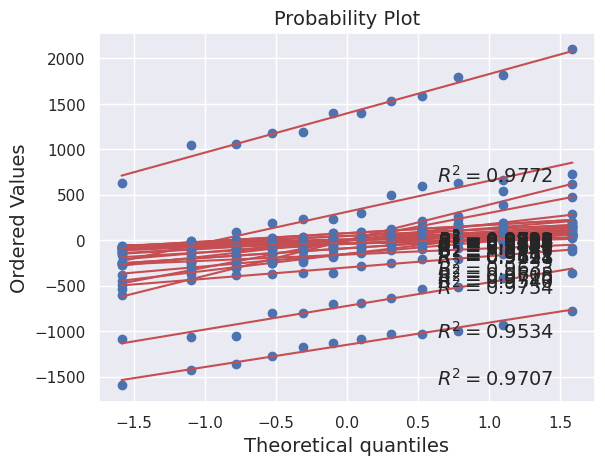

In [163]:
# посмотрим на смещение R^2 у рядов до и после выделения тренда
for j in range(16):
  fig1 = stats.probplot(qoddt[j], plot=plt, rvalue=True)
  fig2 = stats.probplot(ssn_waltp[j], plot=plt, rvalue=True)
  if round(fig1[-1][-1]**2-fig2[-1][-1]**2, 3) <= 0:
      qoddt[j] = ssn_waltp[j]
      print('Q' + str(j+1) + ' before trend subtraction (best result): r^2 = ' + format(fig2[-1][-1]**2, '.4g'))
  else:
      print('Q' + str(j+1) + ' R^2 improvement after trend subtraction: +' + format(fig1[-1][-1]**2-fig2[-1][-1]**2, '.3g') + ' resulting in r^2 = ' + format(fig1[-1][-1]**2, '.4g'))

### Выделение сезонности

In [164]:
qodds1, qodds2, qodds3, qodds4, qodds5, qodds6, qodds7, qodds8, qodds9, qodds10, qodds11, qodds12, qodds13, qodds14, qodds15, qodds16 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i in range(12):
  qodds1.append(qoddt[0][i]-338.2801*math.sin(0.683*(2*i+1)+0.8495)-1380.2966)
  qodds2.append(qoddt[1][i]-302.3497*math.sin(0.714*(2*i+1)-0.4368)+27.965)
  qodds3.append(qoddt[2][i]-198.1385*math.sin(0.757*(2*i+1)+3.0164)+1147.2838)
  qodds4.append(qoddt[3][i]-149.9748*math.sin(0.8727*(2*i+1)+1.9902)+151.7084)
  qodds5.append(qoddt[4][i]-92.5597*math.sin(0.757*(2*i+1)+2.1645)+84.7953)
  qodds6.append(qoddt[5][i]-214.1079*math.sin(0.748*(2*i+1)+2.3752)-10.6195)
  qodds7.append(qoddt[6][i]-75.3903*math.sin(0.6614*(2*i+1)-1.0671)+305.5487)
  qodds8.append(qoddt[7][i]-64.8825*math.sin(0.748*(2*i+1)-0.7352)+1.3626)
  qodds9.append(qoddt[8][i]-25.5982*math.sin(0.5984*(2*i+1)+0.7234)-8.1498)
  qodds10.append(qoddt[9][i]-48.1767*math.sin(1.0134*(2*i+1)+1.6129)-8.3122)
  qodds11.append(qoddt[10][i]-89.1441*math.sin(1.0472*(2*i+1)-1.308)-77.635)
  qodds12.append(qoddt[11][i]-61.8904*math.sin(0.8727*(2*i+1)-0.973)-46.4486)
  qodds13.append(qoddt[12][i]-27.6512*math.sin(1.0649*(2*i+1)+3.0701)+36.5165)
  qodds14.append(qoddt[13][i]-81.5248*math.sin(0.6981*(2*i+1)+2.3238)+31.8725)
  qodds15.append(qoddt[14][i]-56.0413*math.sin(0.3927*(2*i+1)-2.7903)-11.4992)
  qodds16.append(qoddt[15][i]-23.9952*math.sin(0.4189*(2*i+1)+2.4171)-4.2817)
qodds = np.array([qodds1, qodds2, qodds3, qodds4, qodds5, qodds6, qodds7, qodds8, qodds9, qodds10, qodds11, qodds12, qodds13, qodds14, qodds15, qodds16])

Q1 before season subtraction (best result): r^2 = 0.9772
Q2 R^2 improvement after season subtraction: +0.00389 resulting in r^2 = 0.9579
Q3 before season subtraction (best result): r^2 = 0.9707
Q4 before season subtraction (best result): r^2 = 0.9633
Q5 R^2 improvement after season subtraction: +0.0039 resulting in r^2 = 0.965
Q6 R^2 improvement after season subtraction: +0.00428 resulting in r^2 = 0.9783
Q7 before season subtraction (best result): r^2 = 0.971
Q8 before season subtraction (best result): r^2 = 0.9767
Q9 before season subtraction (best result): r^2 = 0.9147
Q10 before season subtraction (best result): r^2 = 0.8441
Q11 before season subtraction (best result): r^2 = 0.9727
Q12 before season subtraction (best result): r^2 = 0.9707
Q13 R^2 improvement after season subtraction: +0.0128 resulting in r^2 = 0.8943
Q14 before season subtraction (best result): r^2 = 0.964
Q15 R^2 improvement after season subtraction: +0.000887 resulting in r^2 = 0.9428
Q16 before season subtractio

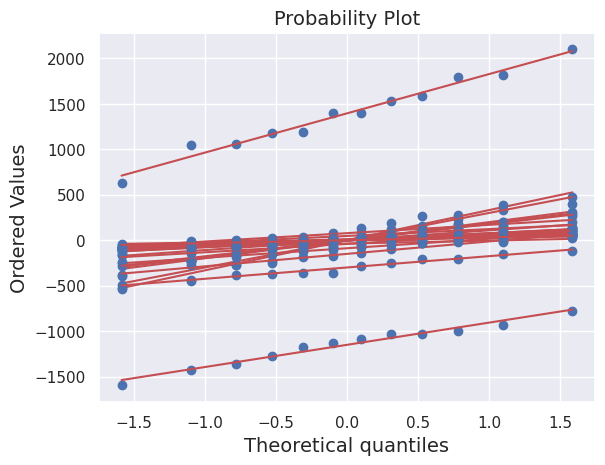

In [165]:
# посмотрим на смещение R^2 у рядов до и после выделения сезонности
for j in range(16):
  fig1 = stats.probplot(qoddt[j], plot=plt, rvalue=False)
  fig2 = stats.probplot(qodds[j], plot=plt, rvalue=False)
  if round(fig2[-1][-1]**2-fig1[-1][-1]**2, 3) <= 0:
      qodds[j] = qoddt[j]
      print('Q' + str(j+1) + ' before season subtraction (best result): r^2 = ' + format(fig1[-1][-1]**2, '.4g'))
  else:
      print('Q' + str(j+1) + ' R^2 improvement after season subtraction: +' + format(fig2[-1][-1]**2-fig1[-1][-1]**2, '.3g') + ' resulting in r^2 = ' + format(fig2[-1][-1]**2, '.4g'))

## Цикл 26

### Выделение сезонности


```
qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i in range(1, 25, 2):
  qoddt1.append(ssn_walsh[i][0])
  qoddt2.append(ssn_walsh[i][1])
  qoddt3.append(ssn_walsh[i][2])
  qoddt4.append(ssn_walsh[i][3])
  qoddt5.append(ssn_walsh[i][4])
  qoddt6.append(ssn_walsh[i][5])
  qoddt7.append(ssn_walsh[i][6])
  qoddt8.append(ssn_walsh[i][7])
  qoddt9.append(ssn_walsh[i][8])
  qoddt10.append(ssn_walsh[i][9])
  qoddt11.append(ssn_walsh[i][10])
  qoddt12.append(ssn_walsh[i][11])
  qoddt13.append(ssn_walsh[i][12])
  qoddt14.append(ssn_walsh[i][13])
  qoddt15.append(ssn_walsh[i][14])
  qoddt16.append(ssn_walsh[i][15])
ssn_waltp26 = np.array([qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16])
```



In [166]:
ssn_waltp26 = np.array([[1729.39000000000, 1656.22000000000, 503.410000000000,
        1926.99000000000, 1465.67000000000, 904.320000000000,
        891.290000000000, 1094.84000000000, 1801.00000000000,
        1392.80000000000, 1693.16000000000, 839.370000000000],
       [263.050000000000, 762.540000000000, -34.3700000000000,
        539.590000000000, 200.230000000000, 285.780000000000,
        220.570000000000, 236.860000000000, 331.840000000000,
        303.620000000000, 507.320000000000, 238.550000000000],
       [-830.390000000000, -476.360000000000, -341.870000000000,
        -943.870000000000, -725.530000000000, -428.800000000000,
        -507.370000000000, -525.880000000000, -994.220000000000,
        -601.400000000000, -863.760000000000, -527.630000000000],
       [-141.770000000000, 11.2399999999999, -15.3700000000000,
        -309.190000000000, -266.490000000000, -25.6999999999999,
        10.1900000000000, -46.7800000000001, -149.380000000000,
        -141.020000000000, -104.520000000000, -82.8900000000000],
       [-50.2700000000001, -443.080000000000, 96.0100000000000,
        -216.910000000000, -148.570000000000, -1.51999999999998,
        -30.5900000000000, -56.8400000000000, -64.4200000000000,
        -141.460000000000, -107.640000000000, 9.37000000000002],
       [-44.6900000000001, -479.480000000000, 58.7500000000000,
        -237.270000000000, -110.170000000000, -195.700000000000,
        -111.990000000000, -115.420000000000, -201.100000000000,
        -107.480000000000, -322.640000000000, -112.330000000000],
       [-350.130000000000, -259.780000000000, -182.030000000000,
        -305.690000000000, -295.930000000000, -270.200000000000,
        -202.930000000000, -206.720000000000, -386.800000000000,
        -249.740000000000, -374.040000000000, -218.430000000000],
       [-58.6299999999999, -28.0200000000000, -44.6900000000000,
        -132.530000000000, 43.5100000000000, -17.3000000000001,
        -43.0900000000000, -22.3800000000000, 25.4000000000000,
        -92.0400000000000, 34.2000000000000, -14.9700000000000],
       [-177.470000000000, -19.9200000000000, 47.8900000000000,
        11.5500000000000, -38.3100000000000, 5.53999999999998,
        -4.19000000000001, 30.1000000000000, 73.8000000000000,
        47.2200000000000, 109.280000000000, 111.770000000000],
       [29.9500000000000, 14.6800000000000, -10.9700000000000,
        54.1100000000000, -25.9900000000000, 67.2400000000000,
        51.9300000000000, 68.9200000000000, 2.95999999999997,
        37.8000000000000, 57.2800000000000, 71.4300000000000],
       [40.6700000000000, 64.7000000000000, -23.1500000000000,
        221.250000000000, 65.4900000000000, 28.9800000000000,
        54.7100000000000, 77.6200000000000, 29.7400000000000,
        50.0600000000000, -20.6400000000000, -14.7900000000000],
       [63.6100000000000, 16.5800000000000, 8.75000000000000,
        173.330000000000, 96.7700000000000, -87.4400000000000,
        -59.7700000000000, -1.59999999999999, 107.860000000000,
        79.7200000000000, 75.4800000000000, -21.6500000000000],
       [-35.2500000000000, -152.740000000000, -14.1500000000000,
        -101.750000000000, -118.590000000000, -49.1400000000000,
        -49.4700000000000, 40.9400000000000, -90.6200000000000,
        62.0800000000000, -65.1200000000000, 9.77000000000000],
       [7.12999999999998, -188.620000000000, 18.9500000000000,
        -54.7100000000000, -48.0300000000000, -75.8800000000000,
        -12.3500000000000, -32.6000000000000, -8.41999999999999,
        -111.700000000000, -240.520000000000, -56.0100000000000],
       [-127.670000000000, -95.2800000000000, -70.9900000000000,
        -261.730000000000, -38.8700000000000, -58.2200000000000,
        -75.9300000000000, -283.420000000000, -179.280000000000,
        -223.240000000000, -154.120000000000, -158.070000000000],
       [-160.570000000000, -11.1600000000000, 3.82999999999999,
        -160.930000000000, 44.8100000000000, 5.72000000000000,
        -37.7300000000000, -99.5600000000000, -124.120000000000,
        1.02000000000000, 28.2800000000000, -34.7700000000000]])

```
qodds1, qodds2, qodds3, qodds4, qodds5, qodds6, qodds7, qodds8, qodds9, qodds10, qodds11, qodds12, qodds13, qodds14, qodds15, qodds16 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i in range(12):
  qodds1.append(qoddt[0][i]-373.149*math.sin(0.6981*(2*i)+0.9067)-1347.046)
  qodds2.append(qoddt[1][i]-75.6063*math.sin(0.714*(2*i)-0.7436)-315.6648)
  qodds3.append(qoddt[2][i]-191.7579*math.sin(0.683*(2*i)-1.6791)+666.1825)
  qodds4.append(qoddt[3][i]-115.7093*math.sin(0.6545*(2*i)-1.3034)+117.7598)
  qodds5.append(qoddt[4][i]-64.5218*math.sin(0.7757*(2*i)+2.2598)+96.13)
  qodds6.append(qoddt[5][i]-65.2069*math.sin(0.7222*(2*i)+1.9875)+159.7115)
  qodds7.append(qoddt[6][i]-59.5415*math.sin(0.6614*(2*i)-2.0666)+277.179)
  qodds8.append(qoddt[7][i]-18.7654*math.sin(0.5236*(2*i)+1.6113)+29.2117)
  qodds9.append(qoddt[8][i]-55.9682*math.sin(0.4654*(2*i)-2.152)-11.8517)
  qodds10.append(qoddt[9][i]-20.1957*math.sin(0.5236*(2*i)+1.2638)-34.945)
  qodds11.append(qoddt[10][i]-47.3655*math.sin(0.6981*(2*i)+1.8076)-53.1711)
  qodds12.append(qoddt[11][i]-78.402*math.sin(0.6283*(2*i)+2.2871)-46.7021)
  qodds13.append(qoddt[12][i]-33.0763*math.sin(0.9817*(2*i)+1.0605)+44.7738)
  qodds14.append(qoddt[13][i]-64.3371*math.sin(0.7222*(2*i)+1.8062)+61.4294)
  qodds15.append(qoddt[14][i]-61.9781*math.sin(0.6981*(2*i)-0.8863)+150.4725)
  qodds16.append(qoddt[15][i]-65.2249*math.sin(0.757*(2*i)-1.919)+48.0698)
qodds26 = np.array([qodds1, qodds2, qodds3, qodds4, qodds5, qodds6, qodds7, qodds8, qodds9, qodds10, qodds11, qodds12, qodds13, qodds14, qodds15, qodds16])
qodds
```

In [167]:
qodds26 = np.array([[88.4988331978846, 31.6370135198806, -646.213074800210,
        926.069902259874, 41.4525619832157, -815.662898284674,
        -508.150758420252, 102.527846795337, 629.590828293603,
        -247.959883630157, 68.4347325759543, -310.433789392911],
       [-1.43371830254125, 399.076273672693, -414.820558658730,
        253.284605066777, -42.2926774561581, -38.4262698969190,
        -170.668021893779, -91.7732122235917, 88.0573126459594,
        21.3829195131638, 129.287387370206, -128.293837561593],
       [26.4268689245750, 248.885735719662, 157.701245456156,
        -404.517446707551, 55.6775134662441, 410.997202427003,
        114.402748358839, -51.3752247165235, -361.589882485035,
        242.813279838498, -91.6136802606517, 3.62096677067677],
       [87.5870356617976, 128.351831306729, -9.54284510699152,
        -248.722170048050, -66.4537220619401, 191.940722422277,
        97.3749013558246, -44.7276737627932, -60.9392128712825,
        77.2708093087069, 94.5968980552967, -23.5481575444980],
       [-3.94307608933565, -306.902727329432, 243.496518655607,
        -158.835141950671, -105.272686030549, 130.615750371737,
        119.769357052771, 5.38781838512486, -23.8344301775571,
        -13.5823991194216, 45.2659266390163, 75.9547498738937],
       [55.3944790510395, -301.103238466092, 282.794408313854,
        -80.0041430822170, -15.4080040609178, -49.9179315429698,
        109.159114566140, 73.7105882826179, -95.4089714640006,
        9.19276574316342, -119.758957968321, 101.304142956753],
       [-20.5790911523895, 57.7139076166798, 62.5686533151581,
        -84.8203869499482, -13.8142918114596, 65.7119362712547,
        98.1457092228770, 23.4575356340535, -156.591863641996,
        51.3813325815327, -38.1362668436651, 63.6360577225823],
       [-48.1683093388325, -7.52520606359457, -5.44515975239805,
        -84.5682962439154, 81.4384839811871, 1.87844325325631,
        -32.6282981723247, -1.88496189830928, 64.6450732453439,
        -44.0783074124471, 72.1282398149609, 4.20821025659748],
       [-142.543343981978, 20.8110426264486, 52.0639825181513,
        -33.7436079691821, -106.129895439933, -39.7173645924215,
        0.0272710633479480, 70.8465024383182, 108.701832440073,
        38.6118149465725, 54.5487731275771, 45.4601217704597],
       [-24.2464615370770, -35.1761155982789, -41.5745908163774,
        38.4165063722517, -46.0239844657671, 27.9544459175812,
        -2.26655120638727, 19.0640845306179, -27.6443010190192,
        22.1065960394838, 37.2458154037265, 32.1441561206915],
       [-58.5447609025057, 14.4734820739539, -29.2544287673991,
        181.486278803636, -30.0897631787782, -52.3321487872892,
        34.1707653561746, 63.9269516322523, -42.3474520447741,
        -49.1610939532679, -70.8934935604919, -20.8974676247739],
       [-42.2258589679074, 0.561186824991609, 40.1471361188302,
        144.218101167493, -17.1587539138982, -193.285397353348,
        -75.8021833412362, 29.7984103445816, 78.7622589383708,
        -34.2012771579956, -30.3749337078808, -37.6955545606307],
       [-19.3385730733848, -111.850056760862, 62.4580636394564,
        -77.4516215578691, -89.9828641601552, 28.4798005108743,
        -13.6629856712368, 59.7290993220312, -16.9961664229107,
        110.762727059696, -52.1873076993984, 74.9993882691595],
       [5.99669987115165, -120.191264413269, 144.706773227075,
        15.9382873583986, -48.6037065427075, -39.3017159844703,
        104.817041014546, 67.7330948954503, 7.08016193355033,
        -100.753978400203, -145.889235696212, 64.2735092624835],
       [70.8192650224640, 24.9416110308759, 20.9559338808995,
        -101.339982701663, 173.574622191333, 103.865413705926,
        16.6049505885372, -164.689148466829, 18.1023268144103,
        -24.7283817364873, -33.8675171918688, -66.1356938492797],
       [-51.1896319144985, 62.6096342433081, -6.49302499455689,
        -145.189464615333, 147.602232120670, 92.3317894418111,
        -40.0068987077444, -95.7481302885750, -30.7281745682172,
        98.4932119799843, 36.6366225712435, -40.6123122293791]])

Q1 R^2 improvement after season subtraction: +0.00589 resulting in r^2 = 0.9462
Q2 R^2 improvement after season subtraction: +0.0708 resulting in r^2 = 0.9565
Q3 R^2 improvement after season subtraction: +0.00846 resulting in r^2 = 0.9522
Q4 before season subtraction (best result): r^2 = 0.92
Q5 R^2 improvement after season subtraction: +0.0902 resulting in r^2 = 0.9545
Q6 R^2 improvement after season subtraction: +0.0512 resulting in r^2 = 0.9496
Q7 before season subtraction (best result): r^2 = 0.9612
Q8 before season subtraction (best result): r^2 = 0.9551
Q9 R^2 improvement after season subtraction: +0.0531 resulting in r^2 = 0.929
Q10 before season subtraction (best result): r^2 = 0.9288
Q11 before season subtraction (best result): r^2 = 0.7909
Q12 before season subtraction (best result): r^2 = 0.9809
Q13 before season subtraction (best result): r^2 = 0.99
Q14 R^2 improvement after season subtraction: +0.11 resulting in r^2 = 0.9826
Q15 R^2 improvement after season subtraction: +0

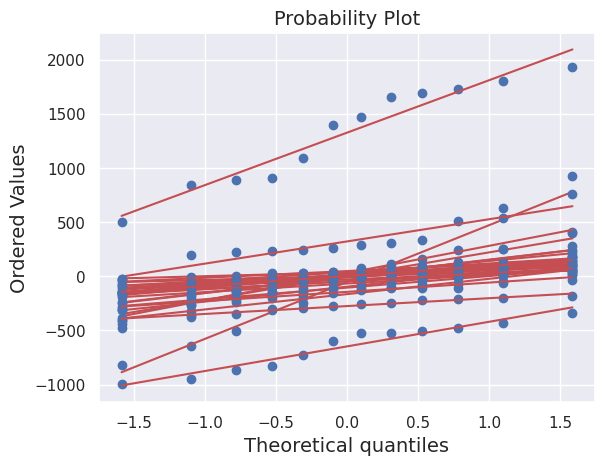

In [168]:
# посмотрим на смещение R^2 у рядов до и после выделения сезонности
for j in range(16):
  fig1 = stats.probplot(ssn_waltp26[j], plot=plt, rvalue=False)
  fig2 = stats.probplot(qodds26[j], plot=plt, rvalue=False)
  if round(fig2[-1][-1]**2-fig1[-1][-1]**2, 3) <= 0:
      qodds26[j] = ssn_waltp26[j]
      print('Q' + str(j+1) + ' before season subtraction (best result): r^2 = ' + format(fig1[-1][-1]**2, '.4g'))
  else:
      print('Q' + str(j+1) + ' R^2 improvement after season subtraction: +' + format(fig2[-1][-1]**2-fig1[-1][-1]**2, '.3g') + ' resulting in r^2 = ' + format(fig2[-1][-1]**2, '.4g'))

### Выделение тренда

In [169]:
# коэффициенты разложения для четных циклов после выделения тренда
qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i in range(12):
  qoddt1.append(np.array(qodds26[0][i]+3.9528*(2*i)+1.9632))
  qoddt2.append(np.array(qodds26[1][i]+41.3003*np.log(2*i+1e-7)-97.6994))
  qoddt3.append(np.array(qodds26[2][i]+5.4594*(2*i)-100.2579))
  qoddt4.append(np.array(qodds26[3][i]-0.3852*(2*i)+110.1482))
  qoddt5.append(np.array(qodds26[4][i]-54.6714*np.log(2*i+1e-7)+128.2777))
  qoddt6.append(np.array(qodds26[5][i]-10.9246*np.log(2*i+1e-7)+28.2734))
  qoddt7.append(np.array(qodds26[6][i]-7.465*np.log(2*i+1e-7)+292.8097))
  qoddt8.append(np.array(qodds26[7][i]-2.229*(2*i)+58.1885))
  qoddt9.append(np.array(qodds26[8][i]-61.5732*np.log(2*i+1e-7)+139.4906))
  qoddt10.append(np.array(qodds26[9][i]-2.0887*(2*i+1e-7)-7.7918))
  qoddt11.append(np.array(qodds26[10][i]+3.0788*(2*i)-87.9112))
  qoddt12.append(np.array(qodds26[11][i]+10.132*np.log(2*i+1e-7)-61.5355))
  qoddt13.append(np.array(qodds26[12][i]-4.1107*(2*i)+100.4424))
  qoddt14.append(np.array(qodds26[13][i]+1.503*(2*i)-15.8579))
  qoddt15.append(np.array(qodds26[14][i]+5.0009*(2*i)-68.1862))
  qoddt16.append(np.array(qodds26[15][i]-9.7206*np.log(2*i+1e-7)+20.6202))
qoddt26 = np.array([qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16])

Q1 R^2 improvement after trend subtraction: +0.00499 resulting in r^2 = 0.9512
Q2 before trend subtraction (best result): r^2 = 0.9565
Q3 before trend subtraction (best result): r^2 = 0.9522
Q4 R^2 improvement after trend subtraction: +0.00815 resulting in r^2 = 0.9282
Q5 before trend subtraction (best result): r^2 = 0.9545
Q6 R^2 improvement after trend subtraction: +0.0189 resulting in r^2 = 0.9685
Q7 before trend subtraction (best result): r^2 = 0.9612
Q8 before trend subtraction (best result): r^2 = 0.9551
Q9 before trend subtraction (best result): r^2 = 0.929
Q10 before trend subtraction (best result): r^2 = 0.9288
Q11 R^2 improvement after trend subtraction: +0.0474 resulting in r^2 = 0.8383
Q12 before trend subtraction (best result): r^2 = 0.9809
Q13 before trend subtraction (best result): r^2 = 0.99
Q14 before trend subtraction (best result): r^2 = 0.9826
Q15 before trend subtraction (best result): r^2 = 0.9734
Q16 before trend subtraction (best result): r^2 = 0.9759


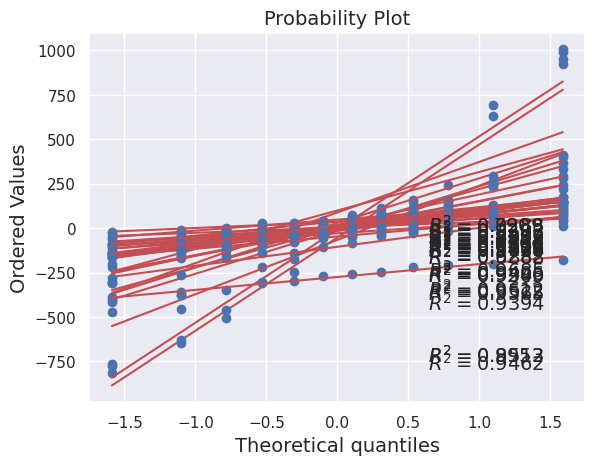

In [170]:
# посмотрим на смещение R^2 у рядов до и после выделения тренда
for j in range(16):
  fig1 = stats.probplot(qodds26[j], plot=plt, rvalue=True)
  fig2 = stats.probplot(qoddt26[j], plot=plt, rvalue=True)
  if round(fig2[-1][-1]**2-fig1[-1][-1]**2, 3) <= 0:
      qoddt26[j] = qodds26[j]
      print('Q' + str(j+1) + ' before trend subtraction (best result): r^2 = ' + format(fig1[-1][-1]**2, '.4g'))
  else:
      print('Q' + str(j+1) + ' R^2 improvement after trend subtraction: +' + format(fig2[-1][-1]**2-fig1[-1][-1]**2, '.3g') + ' resulting in r^2 = ' + format(fig2[-1][-1]**2, '.4g'))

# Экстраполяция и свертка

Проводится прогноз экстраполяцией тренда T + сезонности S + дисперсии D для рядов Q1-Q16, отдельно для последовательностей четных и нечетных циклов.

Есть много нюансов при *последовательном* выделении тренда и сезонного компонента:
*   где-то и тренд, и сезон улучшили случайность ряда остатков (11);
*   где-то тренд улучшил случайность ряда остатков, а сезон - нет (10), и наоборот (01);
*   где-то аппроксимации не нужны вообще для наилучшей случайности ряда остатков (00).

Придумала 4 подхода к учету таких случаев:

*   Means: 00+01+10 значения заменяются средним значением за нечетные циклы, 11 сумма значений экстраполяции тренда и сезонности;
*   Attempt 1: 00 взвешенная по r^2 сумма экстраполяции тренда и сезонности, 01 только экстраполяция сезонности, 10+11 сумма экстраполяции тренда и сезонности;
*   Main try: 00+10 взвешенная по r^2 сумма экстраполяции тренда и сезонности, 01 только экстраполяция сезонности, 11 сумма экстраполяции тренда и сезонности;
*   Exp try: для коэффициентов разложения с 1 по 4 (q1-q4) 00+10 взвешенная по r^2 сумма экстраполяции тренда и сезонности, 11 сумма экстраполяции тренда и сезонности; q5-q16 средние значения за нечетные циклы.

При построении прогноза будем пользоваться подходом main try. Остальные методы разрабатывались в целях удовлетворения интереса и не представляют существенной ценности.


## Цикл 25

In [171]:
# найдем средние значения разложений за нечетные циклы для всех 16 коэффициентов
means = []
mas = np.transpose(ssn_walsh)
for i in range(16):
  meanss = []
  for j in range(0, 24, 2):
      meanss.append(mas[i][j])
  means.append(np.mean(meanss))
  print(format(means[i], '.4g'), end='\n')

1396
312.2
-723.2
-150.2
-88.43
-150.6
-299.9
1.835
11.11
6.567
77.62
46.88
-36.60
-40.63
-157.7
-29.95


In [172]:
# means: 00+01+10 средние за нечетные циклы, 11 сумма
#ssn_extra = [1396, 155.6813, -723.2, -150.2, -88.43, -73.5463, -299.9, 1.835, 11.11, 6.567, 77.62, 46.88, -36.60, -40.63, -161.5289, -29.95]
# attempt 1: 00 взвешенная по r^2 сумма, 01 сезон, 10 сумма, 11 сумма
#ssn_extra = [1295.349561, 155.6813, -869.7238574, -289.8425581, -12.19604234, -73.5463, -414.3491047, -57.90837766, 26.09183344, 39.41312584, 57.96008169, 100.2450119, -63.84666414, 24.63560442, -161.5289, -17.58230951]
# main try: 00 взвешенная по r^2 сумма, 01 сезон, 10 взвешенная по r^2 сумма, 11 сумма
ssn_extra = [1295.349561, 155.6813, -804.412, -289.8425581, -12.19604234, -73.5463, -414.3491047, -57.90837766, 26.09183344, 39.41312584, 57.96008169, 100.2450119, -63.84666414, 24.63560442, -161.5289, 3.248601]
# exp try: q1-q4 00+10 взвешенная по r^2 сумма, 10 не было, 11 сумма; q5-q16 средние за нечетные циклы
#ssn_extra = [1295.349561, 155.6813, -804.4123635, -289.8425581, -88.43, -73.54625568, -299.9, 1.835, 11.11, 6.567, 77.62, 46.88, -36.6, -40.63, -161.5288868, -29.95]

ssn_walsh.append(ssn_extra)

In [173]:
numer1 = [0, 15, 7, 8, 3, 12, 4, 11, 1, 14, 6, 9, 2, 13, 5, 10] #переходим от нумерации Грея к нумерации Адамара
ssn_forecasted = [] #финальная функция, которую будем прогонять через ifwht
tmppp = []
for i in range(25):
  tmppp = ssn_walsh[i]
  ssn_forecastedd = []
  for j in numer1:
    ssn_forecastedd.append(tmppp[j])
  ssn_forecasted.append(ssn_forecastedd)

ssn_res = []
for i in range(25):  #применяем обратное преобразование Уолша к матрице 25*16 построчно, преобразованная расположена по Адамару
  ssn_res.append(ifwht(ssn_forecasted[i]))

## Цикл 26

In [174]:
# найдем средние значения разложений за четные циклы для всех 16 коэффициентов
means26 = []
mas = np.transpose(ssn_walsh)
for i in range(16):
  meanss = []
  for j in range(1, 25, 2):
      meanss.append(mas[i][j])
  means26.append(np.mean(meanss))
  print(format(means26[i], '.4g'), end='\n')

1325
321.3
-647.3
-105.1
-96.33
-165.0
-275.2
-29.21
16.44
34.94
47.89
37.64
-47.00
-66.90
-143.9
-45.43


In [175]:
# means: 00+01+10 средние за нечетные циклы, 11 сумма
#ssn_extra26 = [1319.27, 321.3, -647.3, -105.1, -96.33, -91.01, -275.2, -29.21, 16.44, 34.94, 47.89, 37.64, -47, -66.9, -143.9, -45.43]
# attempt 1: 00 взвешенная по r^2 сумма, 01 тренд, 10 сумма, 11 сумма
#ssn_extra26 = [1319.27, 214.02, -777.38, -100.13, -73.58, -91.01, -245.02, -8.87, 44.99, 56.04, 7.86, 29.07, -0.62, -21.17, -274.28, -94.75]
# main try: 00 взвешенная по r^2 сумма, 01 тренд, 10 взвешенная по r^2 сумма, 11 сумма
ssn_extra26 = [1319.27, 184.36, -692.86, -100.13, -54.41, -91.01, -245.02, -8.87, 28.76, 56.04, 7.86, 29.07, -0.62, 1.01, -159.97, -103.81]
# exp try: q1-q4 00+10 взвешенная по r^2 сумма, 01 тренд, 11 сумма; q5-q16 средние за нечетные циклы
#ssn_extra26 = [1319.27, 184.36, -692.86, -100.13, -96.33, -91.01, -275.2, -29.21, 16.44, 34.94, 47.89, 37.64, -47.00, -66.90, -143.90, -45.43]

ssn_walsh.append(ssn_extra26)

In [176]:
#переходим от нумерации Грея к нумерации Адамара
numer1 = [0, 15, 7, 8, 3, 12, 4, 11, 1, 14, 6, 9, 2, 13, 5, 10]
ssn_forecasted = [] #финальная функция, которую будем прогонять через ifwht
tmppp = []
for i in range(26):
  tmppp = ssn_walsh[i]
  ssn_forecastedd = []
  for j in numer1:
    ssn_forecastedd.append(tmppp[j])
  ssn_forecasted.append(ssn_forecastedd)

#применяем обратное преобразование Уолша к матрице 26*16 построчно, преобразованная расположена по Адамару
ssn_res = []
for i in range(26):
  ssn_res.append(ifwht(ssn_forecasted[i]))

# Прогноз формы циклов

Правило Гневышева-Оля для двух предсказаний выполняется:
* в 24 цикле число пятен в максимуме около 140,
* в 25 цикле число пятен в максимуме составит 185+-15,
* в 26 цикле число пятен в максимуме составит 170+-17.

## Цикл 25

In [177]:
for j in range(16):
  if ssn_res[24][j] < 0:
    ssn_res[24][j] = 0
  else:
    continue

# досчитаем ошибки по данным из файла: среднее арифметическое значений (1-r^2) от аппроксимации тренда+сезонности
rsq = [0.71375, 0.60275, 0.72595, 0.6371, 0.5423, 0.51555, 0.6826, 0.6037, 0.79455, 0.78415, 0.70375, 0.80295, 0.6066, 0.75745, 0.6728, 0.84175]
for i in range(16):
  data_errs[i] *= (1+rsq[i])
ssn_top25, ssn_bottom25 = [], []
for i in range(16):
  ssn_top25.append(float(ssn_res[24][i] + data_errs[i]))
  ssn_bottom25.append(float(ssn_res[24][i] - data_errs[i]))

print(ssn_res[24])
print(data_errs)

[0, 0, 30.8484197506250, 83.4985961993750, 121.687556593125, 148.158728291875, 181.589465884375, 184.885604005625, 136.080472365625, 122.923113584375, 80.2361445518750, 74.3196952231250, 69.8651772143750, 45.1584838456250, 39.9296463681250, 1.32139734687500]
[3.7474, 5.6269881250000005, 9.448137958333334, 11.896259999999998, 11.9348315, 12.907434166666665, 14.9877595, 14.668509333333333, 14.151522208333336, 13.31867975, 11.121228124999998, 10.53824275, 8.252568666666667, 6.95071475, 5.166164, 3.993527916666667]


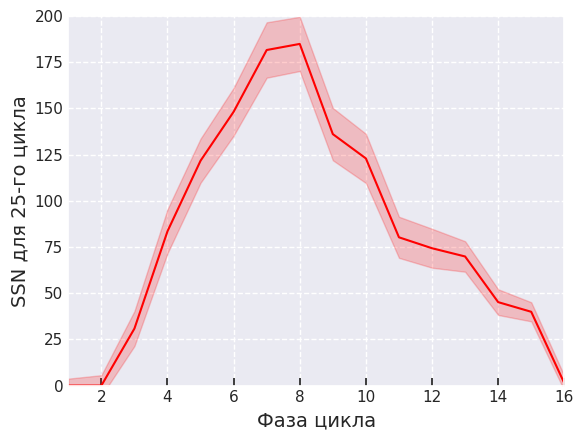

In [178]:
plt.plot(range(1,17), ssn_res[24], color='red')
ax = plt.gca()
ax.set_xlim(1,16)
ax.set_ylim(0,200)
ax.set_xlabel('Фаза цикла')
ax.set_ylabel('SSN для 25-го цикла')
ax.tick_params(axis='both', direction='in', labelbottom=1, bottom=1)
ax.grid(visible='True', which='major', linestyle='--')
plt.fill_between(range(1,17), ssn_top25, ssn_bottom25, color ='red', alpha = 0.2)
plt.tick_params(axis='both', direction='in', labeltop=0, top=0)
plt.show()

## Цикл 26

In [179]:
for j in range(16):
  if ssn_res[25][j] < 0:
    ssn_res[25][j] = 0
  else:
    continue

# досчитаем ошибки по данным из файла: среднее арифметическое значений (1-r^2) от аппроксимации тренда+сезонности
rsq26 = [0.8162, 0.95155, 0.77965, 0.9993, 0.89745, 0.94215, 0.78975, 0.91335, 0.66065, 0.79355, 0.8821, 0.699, 0.828, 0.8272, 0.7744, 0.78795]
for i in range(16):
  data_errs26[i] *= (1+rsq26[i])
ssn_top26, ssn_bottom26 = [], []
for i in range(16):
  ssn_top26.append(float(ssn_res[25][i] + data_errs26[i]))
  ssn_bottom26.append(float(ssn_res[25][i] - data_errs26[i]))

print(ssn_res[25])
print(data_errs26)

[10.6043750000000, 28.3118750000000, 45.3018750000000, 93.4418750000000, 123.240625000000, 150.278125000000, 130.815625000000, 169.820625000000, 128.053125000000, 121.995625000000, 94.7181250000000, 87.1431250000000, 46.9393750000000, 45.7768750000000, 28.0568750000000, 14.7718750000000]
[3.720183, 6.205928999999999, 8.701005458333334, 15.094714999999999, 15.576483291666667, 15.896497750000002, 14.768420416666666, 16.612661375, 12.38568125, 13.578668124999997, 12.650848833333333, 10.247801666666666, 8.713466666666665, 7.107807999999999, 5.951633333333333, 4.4058067916666666]


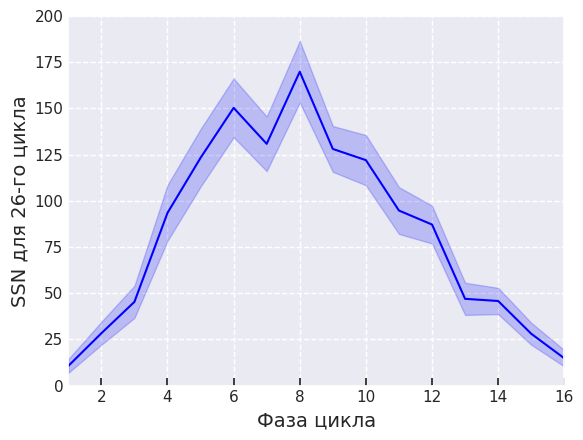

In [180]:
plt.plot(range(1,17), ssn_res[25], color='blue')
ax = plt.gca()
ax.set_xlim(1,16)
ax.set_ylim(0,200)
ax.set_xlabel('Фаза цикла')
ax.set_ylabel('SSN для 26-го цикла')
ax.tick_params(axis='both', direction='in', labelbottom=1, bottom=1)
ax.grid(visible='True', which='major', linestyle='--')
plt.fill_between(range(1,17), ssn_top26, ssn_bottom26, color ='blue', alpha = 0.2)
plt.tick_params(axis='both', direction='in', labeltop=0, top=0)
plt.show()

# Прогноз длительности циклов

## Корреляции параметров циклов

По информации о циклах от [Бельгийской королевской обсерватории](https://sidc.be/SILSO/cyclesmm).

In [181]:
# cycle amplitude in monthly smoothed SSN
A = [144.1, 193, 264.2, 235.3, 82, 81.2, 119.2, 244.9, 219.9, 186.2, 234, 124.4, 146.5, 107.1, 175.7, 130.2, 198.6, 218.7, 285, 156.6, 232.9, 212.5, 180.3, 116.4]
# cycle rise time in years
B = [6.333333333, 3.25, 2.916666667, 3.416666667, 6.833333333, 5.833333333, 6.5, 3.333333333, 4.583333333, 4.166666667, 3.416666667, 5, 3.833333333, 4.083333333, 4.083333333, 4.666666667, 3.583333333, 3.25, 3.916666667, 4.083333333, 3.75, 3.166666667, 5.25, 5.333333333]
# cycle drop time in years
C = [5, 5.75, 6.333333333, 10.16666667, 5.416666667, 7, 4, 6.333333333, 7.833333333, 7.083333333, 8.333333333, 6.25, 8, 7.416666667, 6, 5.416666667, 6.833333333, 6.916666667, 6.583333333, 7.333333333, 6.75, 6.75, 7.083333333, 5.666666667]
#cycle lenghts in years
L = [11.33333333, 9, 9.25, 13.58333333, 12.25, 12.83333333, 10.5, 9.666666667, 12.41666667, 11.25, 11.75, 11.25, 11.83333333, 11.5, 10.08333333, 10.08333333, 10.41666667, 10.16666667, 10.5, 11.41666667, 10.5, 9.916666667, 12.33333333, 11]
# cycle asymmetry as drop time - rise time
D = [-1.333333333, 2.5, 3.416666667, 6.75, -1.416666667, 1.166666667, -2.5, 3, 3.25, 2.916666667, 4.916666667, 1.25, 4.166666667, 3.333333333, 1.916666667, 0.75, 3.25, 3.666666667, 2.666666667, 3.25, 3, 3.583333333, 1.833333333, 0.333333333]
# cycle rise phase duration / cycle duration
BL = [0.56, 0.36, 0.32, 0.25, 0.56, 0.45, 0.62, 0.34, 0.37, 0.37, 0.29, 0.44, 0.32, 0.36, 0.40, 0.46, 0.34, 0.32, 0.37, 0.36, 0.36, 0.32, 0.43, 0.48]
# cycle drop phase duration / cycle duration
CL = [0.44, 0.64, 0.68, 0.75, 0.44, 0.55, 0.38, 0.66, 0.63, 0.63, 0.71, 0.56, 0.68, 0.64, 0.60, 0.54, 0.66, 0.68, 0.63, 0.64, 0.64, 0.68, 0.57, 0.52]

df = pd.DataFrame({'A': A, 'B': B, 'C': C, 'D': D, 'L': L, 'BL': BL})
#sns.pairplot(df)

### Нечетные циклы

Для **нечетных** циклов лучше всего коррелируют:
* D & BL,
* B & BL,
* B & D,
* C & D,
* C & BL,
* A & B.

При p-value < 0.05 (типичное пороговое значение) делаем вывод о том, что взаимосвязь (корреляция) между двумя параметрами статистически значима.
Пример кода для определения статистически значимых корреляций:
```
r = pearsonr(odds['A'], odds['B'])
print('Pearson correlation:', r[0], 'p-value:', r[1])
```
из списка выше p-value для корреляций каждой пары параметров не превосходили 2е-3.

In [182]:
odds = df[df.index % 2 == 0] # нечетные циклы
odds_r = (odds.corr())**2
odds_r.style.background_gradient(cmap="rocket_r")

,A,B,C,D,L,BL
A,1.000000,0.644907,0.255723,0.511663,0.167595,0.549816
B,0.644907,1.000000,0.474424,0.850514,0.190494,0.909864
C,0.255723,0.474424,1.000000,0.838171,0.123655,0.755869
D,0.511663,0.850514,0.838171,1.000000,0.002986,0.985976
L,0.167595,0.190494,0.123655,0.002986,1.000000,0.023324
BL,0.549816,0.909864,0.755869,0.985976,0.023324,1.000000


In [183]:
odds_pairs = [['A', 'B'], ['BL', 'D'], ['B', 'BL'], ['B', 'D'], ['D', 'C'], ['C', 'BL']] #важно, как расставлены столбцы
sc25test = {'A': 185, 'BL': 7/16}
#B: 7 phases, C: 8 phases, D: 1 phase, L: 16 phases

odds_coeff = pd.DataFrame(columns =['X', 'y', 'slope', 'intercept', 'r2', 'y for sc25', 'err for sc25'])
for pair in odds_pairs: # итерация по паре из нечетных циклов
  X = odds[pair[0]].to_numpy().reshape(-1, 1)
  y = odds[pair[1]].to_numpy()
  reg = LinearRegression().fit(X, y)
  r = reg.score(X, y)
  if sc25test[pair[0]] != 0:
    pred = reg.predict(np.array(sc25test[pair[0]]).reshape(-1, 1))
    odds_coeff.loc[len(odds_coeff.index)] = [pair[0], pair[1], reg.coef_[0], reg.intercept_, r, pred[0], pred[0]*(1-r)]
    sc25test.update({pair[1]: pred[0]}) #обновляем всю информацию про цикл, которую получили
  else:
    odds_coeff.loc[len(odds_coeff.index)] = [pair[0], pair[1], reg.coef_[0], reg.intercept_, r, 'nan', 'nan']
print(odds_coeff)

    X   y      slope  intercept        r2  y for sc25  err for sc25
0   A   B  -0.017601   7.930951  0.644907    4.674856      1.660008
1  BL   D -21.758433  10.887777  0.985976    1.368463      0.019191
2   B  BL   0.078448   0.052112  0.909864    0.418846      0.037753
3   B   D  -1.661997   9.548042  0.850514    1.778445      0.265853
4   D   C   0.488258   5.571280  0.838171    6.439620      1.042117
5   C  BL  -0.074395   0.896270  0.755869    0.417192      0.101849


### Четные циклы

Для **четных** циклов лучше всего коррелируют:
* D & BL,
* A & B,
* C & D,
* B & BL,
* A & BL,
* C & L.

При p-value < 0.05 (типичное пороговое значение) делаем вывод о том, что взаимосвязь (корреляция) между двумя параметрами статистически значима.
Пример кода для определения статистически значимых корреляций:
```
r = pearsonr(evens['A'], evens['B'])
print('Pearson correlation:', r[0], 'p-value:', r[1])
```
из списка выше p-value для корреляций каждой пары параметров не превосходили 5е-3.

In [184]:
evens = df[df.index % 2 == 1] #четные циклы
evens_r = evens.corr()
(evens_r**2).style.background_gradient(cmap="rocket_r")

,A,B,C,D,L,BL
A,1.000000,0.776014,0.108519,0.487352,0.087308,0.659174
B,0.776014,1.000000,0.077841,0.524610,0.180567,0.744277
C,0.108519,0.077841,1.000000,0.746817,0.563587,0.510932
D,0.487352,0.524610,0.746817,1.000000,0.100085,0.931736
L,0.087308,0.180567,0.563587,0.100085,1.000000,0.006451
BL,0.659174,0.744277,0.510932,0.931736,0.006451,1.000000


In [185]:
evens_pairs = [['A', 'B'], ['BL', 'D'], ['A', 'BL'], ['D', 'C'], ['B', 'BL'], ['C', 'L']]
sc26test = {'A': 170, 'BL': 7/16}
#B: 7 phases, C: 8 phases, D: 1 phase, L: 16 phases

evens_coeff = pd.DataFrame(columns =['X', 'y', 'slope', 'intercept', 'r2', 'y for sc26', 'err for sc26'])
for pair in evens_pairs: # итерация по паре из четных циклов
  X = evens[pair[0]].to_numpy().reshape(-1, 1)
  y = evens[pair[1]].to_numpy()
  reg = LinearRegression().fit(X, y)
  r = reg.score(X, y)
  if sc26test[pair[0]] != 0:
    pred = reg.predict(np.array(sc26test[pair[0]]).reshape(-1, 1))
    evens_coeff.loc[len(evens_coeff.index)] = [pair[0], pair[1], reg.coef_[0], reg.intercept_, r, pred[0], pred[0]*(1-r)]
    sc26test.update({pair[1]: pred[0]})
  else:
    evens_coeff.loc[len(evens_coeff.index)] = [pair[0], pair[1], reg.coef_[0], reg.intercept_, r, 'nan', 'nan']
print(evens_coeff)

    X   y      slope  intercept        r2  y for sc26  err for sc26
0   A   B  -0.014497   6.555927  0.776014    4.091474      0.916434
1  BL   D -24.334999  11.854237  0.931736    1.207675      0.082441
2   A  BL  -0.001011   0.544954  0.659174    0.373010      0.127131
3   D   C   0.620482   5.159806  0.746817    5.909146      1.496095
4   B  BL   0.065308   0.105983  0.744277    0.373190      0.095433
5   C   L   0.796392   5.524681  0.563587   10.230677      4.464800


## Цикл 25

### Подгонка

Наиболее удобна подгонка по двум точкам реальных данных https://www.swpc.noaa.gov/products/solar-cycle-progression:
* точка 1 - начало цикла в декабре 2019;
* точка 2 - июль 2023, 124 пятна в среднем за месяц, в ssn_res же 124 на пятой фазе из 16.

44 месяца прошло с начала цикла => 44*16/5 = 140,8 месяцев или 11 лет, 8.8 месяцев. Тогда пик в 190 пятен прогнозируется на сентябрь 2025, а конец - на август 2031.

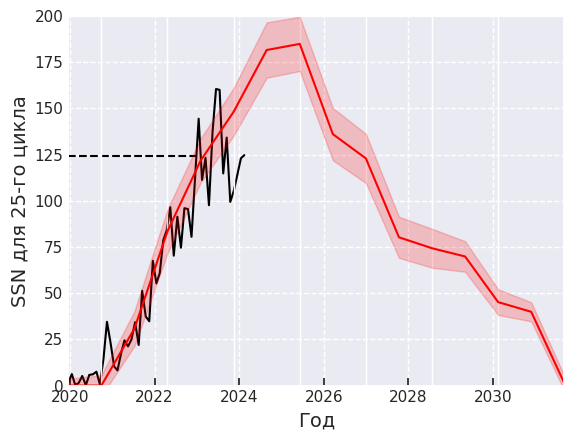

In [186]:
data_25 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sc25input.csv", sep=';', header = 0)
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax2.plot(range(1,17), ssn_res[24], color='red')
ax1.plot(data_25['yearfrac'], data_25['ssn'], color='black')
ax1.axhline(y=124, xmax = 0.26, color='black', linestyle='--')
ax2.set_xlim(1,16)
ax2.set_ylim(0,200)
ax1.set_xlim(2019.958, 2019.958+16*8.8/12) # верхняя граница предсказывается, не cycles_data
ax2.fill_between(range(1,17), ssn_top25, ssn_bottom25, color ='red', alpha = 0.2)
ax1.set_xlabel('Год')
ax1.set_ylabel('SSN для 25-го цикла')
ax2.tick_params(axis='both', direction='in', labeltop=0, top=0)
ax1.tick_params(axis='both', direction='in')
ax1.grid(visible='True', which='major', linestyle='--')
plt.show()

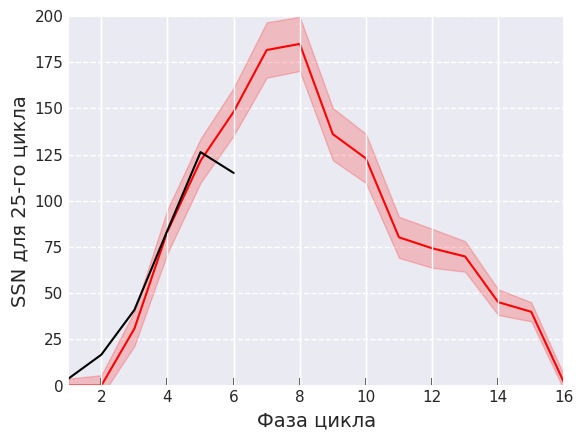

0.8861998525186132


In [187]:
# здесь сравнивается усредненная по 16 фазам структура реальных данных 25 цикла и спрогнозированных. после настоящей фазы (они по 8.8 мес каждая) построила прямую
data25 = [3.715909091, 16.74090909, 40.95909091, 84.03863636, 126.3295455, 115.075]
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(range(1,17), ssn_res[24], color='red')
ax2.plot(range(1,7), data25[:6], color='black')
ax1.set_xlim(1,16)
ax1.set_ylim(0,200)
ax2.set_xlim(1,16)
ax1.set_xlabel('Фаза цикла')
ax1.set_ylabel('SSN для 25-го цикла')
ax1.fill_between(range(1,17), ssn_top25, ssn_bottom25, color ='red', alpha = 0.2)
ax1.tick_params(axis='both', direction='in', labelbottom=1, bottom=1), ax2.tick_params(axis='both', direction='in', labeltop=0, top=0)
ax1.grid(visible='True', which='major', linestyle='--')
plt.show()

# посчитаем r^2 для второго, фазового, графика. r2_score(y, f) - здесь y = настоящие данные, f = прогноз
r2 = r2_score(data25, ssn_res[24][:6])
print(r2)

### По двум похожим

In [188]:
# найдем цикл, максимально похожий на 25 цикл, простым перебором значений r^2
r2 = 0
ind = 0
for n in range(24):
  r2temp = r2_score(ssn_res[24], ssn_res[n])
  if r2temp > r2:
    r2 = r2temp
    ind = n+1
  else:
    continue
print('sc', ind, 'наиболее похож на sc 25 с r^2 =', round(r2, 2))

sc 17 наиболее похож на sc 25 с r^2 = 0.93


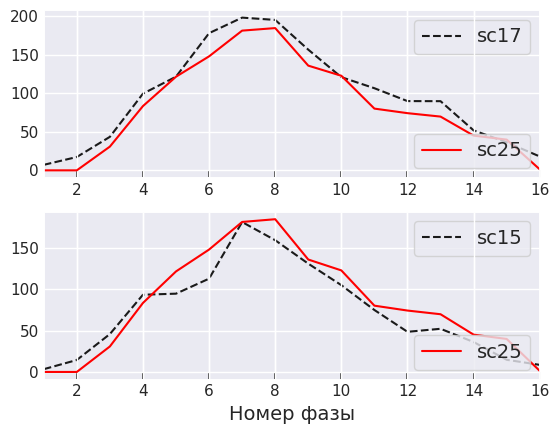

r^2 для sc17 ~ sc25: 0.93 
r^2 для sc15 ~ sc25: 0.91
длительность sc25 по похожим циклам 10 лет 3.02 мес


In [189]:
fig, (ax1, ax3) = plt.subplots(2, 1)
ax1.plot(range(1,17), ssn_res[16], 'k--', label = 'sc17')
ax2 = ax1.twiny()
ax2.plot(range(1,17), ssn_res[24], color='red', label = 'sc25')
ax3.plot(range(1,17), ssn_res[14], 'k--', label = 'sc15')
ax4 = ax3.twiny()
ax4.plot(range(1,17), ssn_res[24], color='red', label = 'sc25')
ax1.set_xlim(1,16), ax2.set_xlim(1,16), ax3.set_xlim(1,16), ax4.set_xlim(1,16)
ax3.set_xlabel('Номер фазы')
ax1.tick_params(axis='both', direction='in')
ax2.tick_params(axis='both', direction='in', labeltop=0, top=0)
ax3.tick_params(axis='both', direction='in')
ax4.tick_params(axis='both', direction='in', labeltop=0, top=0)
handles1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(handles1, labels1)
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc = 'lower right')
handles3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(handles3, labels3)
handles4, labels4 = ax4.get_legend_handles_labels()
ax4.legend(handles4, labels4, loc = 'lower right')
plt.show()

r2_17 = r2_score(ssn_res[24], ssn_res[16])
r2_15 = r2_score(ssn_res[24], ssn_res[14])
print('r^2 для sc17 ~ sc25:', round(r2_17, 2), '\nr^2 для sc15 ~ sc25:', round(r2_15, 2))

dur_17 = 10+5/12
dur_15 = 10+1/12
dur_25_lookalike = (dur_17 * r2_17 + dur_15 * r2_15)/(r2_17 + r2_15)
print('длительность sc25 по похожим циклам', math.floor(dur_25_lookalike), 'лет', round((dur_25_lookalike - math.floor(dur_25_lookalike))*12,2), 'мес')

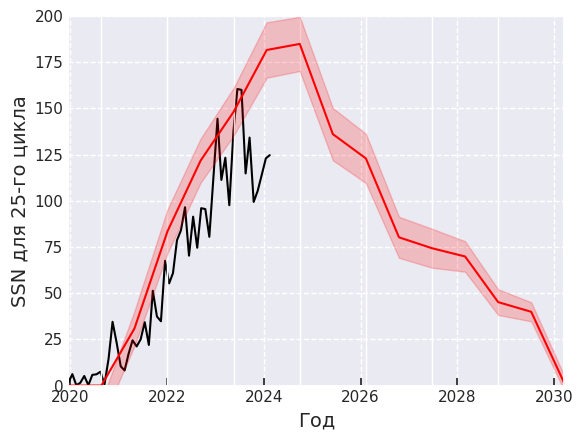

In [190]:
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax2.plot(range(1,17), ssn_res[24], color='red')
ax1.plot(data_25['yearfrac'], data_25['ssn'], color='black')
ax2.set_xlim(1,16)
ax2.set_ylim(0,200)
ax1.set_xlim(2019.958, 2019.958+10+3.02/12) # верхняя граница предсказывается по похожим циклам теперь
ax2.fill_between(range(1,17), ssn_top, ssn_bottom, color ='red', alpha = 0.2)
#ax1.set_xlabel('Номер фазы')
ax1.set_xlabel('Год')
ax1.set_ylabel('SSN для 25-го цикла')
ax2.tick_params(axis='both', direction='in', labeltop=0, top=0)
ax1.tick_params(axis='both', direction='in')
ax1.grid(visible='True', which='major', linestyle='--')
plt.show()

### По корреляциям

## Цикл 26

### По двум похожим

В этот раз подогнать по реальным данным не получится. Если пользоваться аппроксимацией Дмитриевой (2000), длина восходящей ветви 26 цикла, начиная с августа 2031 года, составит около 2,766 лет. Это займет 8 фаз из 16, что приводит к  дате (второго) пика в мае 2034 года и полной длительности 5,532 года. По сравнению с 11 годами - значения немыслимые, такой прогноз публиковать просто нельзя.

In [191]:
# найдем цикл, максимально похожий на 26 цикл, простым перебором значений r^2
r2 = 0
ind = 0
for n in range(25):
  r2temp = r2_score(ssn_res[25], ssn_res[n])
  if r2temp > r2:
    r2 = r2temp
    ind = n+1
  else:
    continue
print('sc', ind, 'наиболее похож на sc 26 с r^2 =', round(r2, 2))

sc 20 наиболее похож на sc 26 с r^2 = 0.87


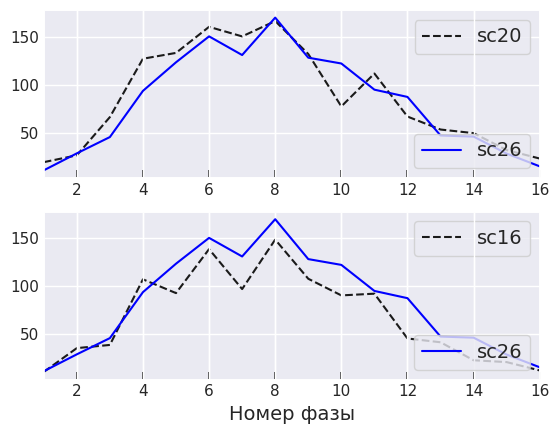

r^2 для sc20 ~ sc26: 0.87 
r^2 для sc16 ~ sc26: 0.83
длительность sc26 по похожим циклам 10 лет 9 мес


In [192]:
fig, (ax1, ax3) = plt.subplots(2, 1)
ax1.plot(range(1,17), ssn_res[19], 'k--', label = 'sc20')
ax2 = ax1.twiny()
ax2.plot(range(1,17), ssn_res[25], color='blue', label = 'sc26')
ax3.plot(range(1,17), ssn_res[15], 'k--', label = 'sc16')
ax4 = ax3.twiny()
ax4.plot(range(1,17), ssn_res[25], color='blue', label = 'sc26')
ax1.set_xlim(1,16), ax2.set_xlim(1,16), ax3.set_xlim(1,16), ax4.set_xlim(1,16)
ax3.set_xlabel('Номер фазы')
ax1.tick_params(axis='both', direction='in')
ax2.tick_params(axis='both', direction='in', labeltop=0, top=0)
ax3.tick_params(axis='both', direction='in')
ax4.tick_params(axis='both', direction='in', labeltop=0, top=0)
handles1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(handles1, labels1)
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc = 'lower right')
handles3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(handles3, labels3)
handles4, labels4 = ax4.get_legend_handles_labels()
ax4.legend(handles4, labels4, loc = 'lower right')
plt.show()

r2_20 = r2_score(ssn_res[25], ssn_res[19])
r2_16 = r2_score(ssn_res[25], ssn_res[15])
print('r^2 для sc20 ~ sc26:', round(r2_20, 2), '\nr^2 для sc16 ~ sc26:', round(r2_16, 2))

dur_20 = 11+5/12
dur_16 = 10+1/12
dur_26_lookalike = (dur_20 * r2_20 + dur_16 * r2_16)/(r2_20 + r2_16)
print('длительность sc26 по похожим циклам', math.floor(dur_26_lookalike), 'лет', round((dur_26_lookalike - math.floor(dur_26_lookalike))*12), 'мес')

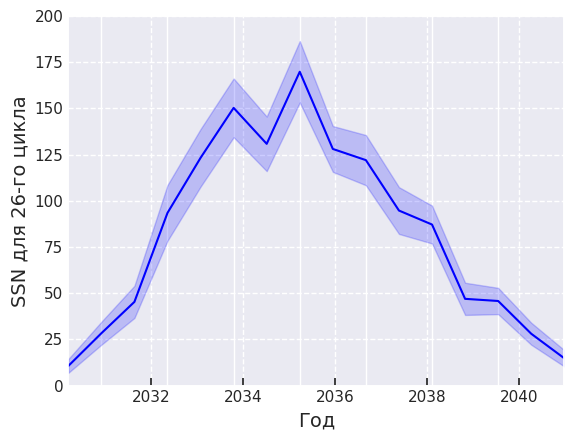

In [193]:
fig, ax = plt.subplots()
ax1 = ax.twiny()
ax1.set_xlim(1,16)
ax.set_xlim(2030.210,2030.210+10+9.22/12)
ax1.plot(range(1,17), ssn_res[25], color='blue')
ax1.set_ylim(0,200)
#ax1.set_xlabel('Фаза цикла')
ax.set_xlabel('Год')
ax.set_ylabel('SSN для 26-го цикла')
ax1.tick_params(axis='both', direction='in', labelbottom=0, bottom=0, labeltop=0, top=0)
ax.tick_params(axis='both', direction='in', labeltop=0, top=0)
ax.grid(visible='True', which='major', linestyle='--')
ax1.fill_between(range(1,17), ssn_top26, ssn_bottom26, color ='blue', alpha = 0.2)
plt.show()

### По корреляциям